# 1、Environmental plot

## 1.0 Load data

In [2]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import joblib


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped



# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_abandon = df_abandon[
    (df_abandon['lon'] >= usa_bounds_main['lon_min']) &
    (df_abandon['lon'] <= usa_bounds_main['lon_max']) &
    (df_abandon['lat'] >= usa_bounds_main['lat_min']) &
    (df_abandon['lat'] <= usa_bounds_main['lat_max'])
]
# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

# ---------------------------
# 3) 特征选择（排除经纬度）
# ---------------------------
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
# 只保留在 df_embedding_fill 列中实际存在的特征（防止有些特征名在数据中不存）
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

gmm_pipeline = joblib.load('gmm_model_23c_fixed.pkl')





                      

gogogo
[OK] TensorFlow available
[OK] scikeras available
[OK] SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


In [3]:


df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')



# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit','area_m2']].copy()
emission_data['Expectation_net_benefit'] = emission_data['Expectation_net_benefit'] * 3.67  # 单位变为MgCO2也就是吨
emission_data = emission_data.rename(columns={'Expectation_net_benefit': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')
merged_data_for_plot

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,area_m2,avg_npv
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,17456.316875,776295.361002,1.186559e+06
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,15043.278268,775385.854124,1.024540e+06
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,16394.927941,775385.854124,1.012824e+06
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,16370.542817,775332.207938,1.006151e+06
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,16465.335782,775332.207938,1.034704e+06
...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,15589.743683,563356.382622,-1.040777e+06
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,15826.804581,563356.382622,-1.044904e+06
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,15635.461040,563356.382622,-1.070065e+06
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,15652.242179,563356.382622,-1.067688e+06


In [4]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")





DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


## 1.1 Help funciton

In [ ]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors):
    """添加颜色条到背景地图下方，并在上方显示数据分布曲线+柱状图"""
    def add_horizontal_cbar_equiv(fig, ax, mappable, var_bins, variable_name, unit_display=None, var_values=None, colors=None):
        # 获取主地图位置
        pos = ax.get_position()
        
        # colorbar放在底部，靠右显示（左边留给similarity分布图）
        # 左侧留出空间给similarity分布图，右侧放置colorbar
        left = pos.x0 + 0.55 * pos.width  # 从中间开始，靠右显示
        bottom = 0.06  # 固定在底部
        width = 0.45 * pos.width  # 宽度减小，靠右显示
        height = 0.035  # colorbar高度

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(50)  
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks(var_bins[1::2])

        # 格式化刻度标签
        tick_vals = var_bins[1::2]
        if variable_name == 'avg_npv':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        elif variable_name == 'predicted_prob':
            tick_labels = [f'{v:.2f}' for v in tick_vals]
        elif variable_name == 'Expectation_net_benefit':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        else:
            tick_labels = [f'{v:.0f}' for v in tick_vals]
        cb.set_ticklabels(tick_labels)

        # 细长
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # 百分位标签
        percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
        major_tick_locs = cb.get_ticks()
        for loc, label in zip(major_tick_locs, percentile_labels):
            # 使用colorbar坐标系统的正确定位方式
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.3, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)
        cax.text(1.02, 1.3, "(%)", ha='center', va='bottom', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)

        # ========== 添加数据分布曲线和柱状图 ==========
        chart_ax = None  # 初始化以便后续引用
        if var_values is not None and colors is not None:
            # 创建图表坐标轴，位置在colorbar上方，与colorbar对齐（靠右）
            chart_height = 0.11  # 图表高度
            chart_bottom = bottom + height + 0.05  # 在colorbar上方
            
            chart_ax = fig.add_axes([left, chart_bottom, width, chart_height])  # 使用相同的left和width，保持对齐
            chart_ax.set_in_layout(False)
            chart_ax.set_zorder(51)
            chart_ax.grid(False)  # 取消grid网格
            
            clean_values = var_values[~np.isnan(var_values)]
            if len(clean_values) > 0:
                # 1. 绘制柱状图（底层）- 使用10%分位数组
                # 定义10个分位数组 (0-10%, 10-20%, ..., 90-100%)
                percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                bin_edges = np.percentile(clean_values, percentiles)
                
                # 计算每个10%分位数段的数据值和颜色
                bar_heights = []
                bar_positions = []
                bar_colors = []
                bar_widths = []
                

                for i in range(10):
                    bin_min = bin_edges[i]
                    bin_max = bin_edges[i+1]
                    
                    # x位置为该分位数段的中间值（百分比）
                    bar_positions.append((percentiles[i] + percentiles[i+1]) / 2)
                    
                    # 计算该分位数段的数据密度
                    count_in_bin = len(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    # y值为该分位数段的平均数值（不归一化）
                    mean_value = np.mean(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    
                    # 直接使用原始均值，不进行归一化
                    bar_heights.append(mean_value)
                    
                    # 柱子宽度
                    bar_widths.append(10)  # 每个柱子宽度为10%
                    
                    # 确定颜色
                    bar_colors.append(colors[i])
                # 绘制柱子（背景）
                for i in range(10):
                    chart_ax.bar(bar_positions[i], bar_heights[i], width=bar_widths[i],
                                color=bar_colors[i], alpha=0.4, edgecolor='none')
                
                # 2. 绘制曲线（顶层）- 使用每个bin的中心点
                chart_ax.plot(bar_positions, bar_heights, color='#333333', linewidth=1.2, alpha=0.8, zorder=10)
                
                # 设置x轴范围：0-100%（对应优先级/分位数）
                chart_ax.set_xlim(0, 100)
                
                # 动态设置y轴范围（不归一化，基于实际数据范围）
                if len(bar_heights) > 0:
                    y_min = min(bar_heights)
                    y_max = max(bar_heights)
                    y_range = y_max - y_min
                    # 设置y轴范围，留出10%的顶部空间
                    chart_ax.set_ylim(y_min - 0.05 * y_range if y_range > 0 else y_min - 0.1, 
                                     y_max + 0.15 * y_range if y_range > 0 else y_max + 0.1)
                else:
                    chart_ax.set_ylim(0, 1.1)
                
                # 3. 不显示x轴刻度和标签
                chart_ax.set_xticks([])
                chart_ax.set_xticklabels([])
                chart_ax.tick_params(axis='x', which='both', length=0, labelsize=0)
                # 显示x轴的实线
                chart_ax.spines['bottom'].set_visible(True)
                chart_ax.spines['bottom'].set_linewidth(1.0)
                chart_ax.spines['bottom'].set_color('#333333')

                # 在x轴末端（100%）添加美观的实心箭头
                from matplotlib.patches import FancyArrowPatch

                # 创建一个实心（三角形）箭头，arrowstyle='simple'
                arrow_solid = FancyArrowPatch(
                    posA=(100, 0), posB=(103, 0),
                    transform=chart_ax.get_xaxis_transform(),  
                    arrowstyle='simple',
                    color='black', linewidth=0, mutation_scale=8, zorder=20
                )
                arrow_solid.set_clip_on(False)
                chart_ax.add_patch(arrow_solid)

            
            # 移除顶部和侧边边框
            chart_ax.spines['top'].set_visible(False)
            chart_ax.spines['right'].set_visible(False)
            chart_ax.spines['left'].set_visible(True)  # 显示左侧Y轴
            chart_ax.spines['bottom'].set_visible(True)  # 显示底部X轴（修改这里）

            # 动态设置y轴刻度和标签，仅显示头、中、尾三个刻度，仅两位小数
            if len(bar_heights) > 0:
                y_min = min(bar_heights)
                y_max = max(bar_heights)
                y_range = y_max - y_min

                # 生成3个刻度：头、中、尾
                if y_range > 0:
                    y_mid = y_min + y_range / 2
                    y_ticks = [y_min, y_mid, y_max]
                    chart_ax.set_yticks(y_ticks)
                    chart_ax.set_yticklabels([f'{v:.2f}' for v in y_ticks], fontsize=5)
                else:
                    chart_ax.set_yticks([y_min])
                    chart_ax.set_yticklabels([f'{y_min:.2f}'], fontsize=5)
            else:
                # 没有数据时，显示0,0.5,1三个刻度
                chart_ax.set_yticks([0, 0.5, 1.0])
                chart_ax.set_yticklabels(['0.00', '0.50', '1.00'], fontsize=5)

            chart_ax.tick_params(axis='y', which='major', length=2.5, width=0.5, pad=2, labelsize=5)
            chart_ax.tick_params(axis='y', which='minor', length=1.5, width=0.4)

            # chart_ax.set_ylabel('Mean', fontsize=5, fontweight='bold', labelpad=2)

            from matplotlib.patches import FancyArrowPatch
            # Y轴箭头位置需要根据实际y_max调整
            y_lim = chart_ax.get_ylim()
            arrow_y = FancyArrowPatch(
                posA=(0, y_lim[1] * 1), posB=(0, y_lim[1]*1.15),
                transform=chart_ax.get_yaxis_transform(),
                arrowstyle='simple',
                color='black', linewidth=0, mutation_scale=8, zorder=20
            )
            arrow_y.set_clip_on(False)
            chart_ax.add_patch(arrow_y)
            
            # 在左上方添加panel 'e'标签
            chart_ax.text(-0.18, 1.08, 'g', transform=chart_ax.transAxes,
                         ha='right', va='bottom', fontsize=7, fontweight='bold',
                         zorder=30)
            
            chart_ax.patch.set_visible(False)
            
            # 添加虚线引线连接colorbar的tick位置到数据分布图的对应位置
            if chart_ax is not None and clean_values is not None and len(clean_values) > 0:
                from matplotlib.lines import Line2D
                
                # 计算每个major_tick_loc对应的百分位数值
                for loc in major_tick_locs:
                    # 找到loc对应的数值在数据中的百分位数
                    pct = (np.sum(clean_values <= loc) / len(clean_values)) * 100
                    
                    # 引线的起点和终点x坐标都使用colorbar的刻度位置（确保垂直线）
                    # 将loc转换为figure坐标
                    x_tick_display, _ = cax.transData.transform((loc, 0))
                    x_tick_fig, _ = fig.transFigure.inverted().transform((x_tick_display, 0))
                    
                    # 起点的y坐标（colorbar顶部）
                    y_start = cax.get_position().y1
                    
                    # 终点的y坐标（数据分布图底部）
                    y_end = chart_ax.get_position().y0
                    
                    # 绘制垂直线（起点和终点的x坐标相同）
                    line = Line2D([x_tick_fig, x_tick_fig], [y_start, y_end],
                                transform=fig.transFigure, color="gray", 
                                lw=0.8, alpha=0.4, linestyle='--', zorder=45)
                    fig.add_artist(line)

        for ch in cax.get_children():
            try:
                ch.set_clip_path(cax.patch)
            except Exception:
                pass

        return cax, cb
    # 控制单位标签
    if variable_name == 'net_npv_usd':
        unit_display = f'{unit} ' #(10⁶)
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} '  #(10³)
    else:
        unit_display = f'{unit} '

    cbar_ax, cbar = add_horizontal_cbar_equiv(fig, ax, scatter, var_bins, variable_name, unit_display, var_values, colors)
    cbar_ax.text(0.5, -1.1, unit_display, ha='center', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)
    return cbar_ax, cbar


def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

## 1.2 Single-variable function

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker

def plot_single_variable(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    绘制单变量地图，简化版本
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和变量数据的数据框
    us_states_gdf : GeoDataFrame
        美国州界数据
    dem_data : xarray.Dataset
        DEM地形数据
    variable_name : str
        要绘制的变量名
    title : str, optional
        图表标题
    unit : str, optional
        变量单位
    colors : list, optional
        颜色列表
    cmap_type : str, default 'sequential'
        颜色映射类型
    add_north_arrow_and_scalebar : bool, default True
        是否添加指北针和比例尺
    add_embedding_points : bool, default False
        是否添加嵌入点
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })


    # 创建更大的图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(85/25.4, 80/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05  
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围 - 图像整体向上移动，比例不变
    ax.set_position([0.07, 0.17, 0.9, 0.9])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换 ====================
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 取消坐标轴和网格 ====================
    # 移除坐标轴边框
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 30,35,40,45]
    
    # 绘制曲线网格线（标签显示在上方）
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    # _draw_background_map(ax, usa_bounds_main)

    # ==================== 10. 数据可视化 ====================
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 4)
    # var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    lower_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50])
    upper_bins = np.nanpercentile(var_values, [70, 85, 100])
    var_bins = np.concatenate([lower_bins, upper_bins])
    # var_values = np.asarray(merged_data_for_plot[variable_name].values, dtype=float)
    # var_bins = np.linspace(0.0, 1.00, 10)
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. 颜色条（传入var_values用于绘制分布图）====================
    _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors)
    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

C:\Users\zpy10\AppData\Local\Temp\ipykernel_4248\2754557448.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


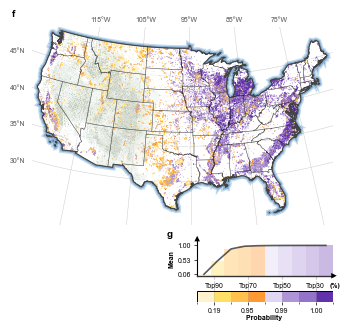

图片生成完成！


In [13]:

# ==================== 主程序 ====================
# 仅保留第一个变量生成

variable_config = {
    'name': 'predicted_prob',
    'title': 'Environmental Potential',
    'unit': 'Probability',
    # 采用单色渐变，逐渐变深为紫色
    'colors': [
        '#fff2cc',
        '#ffe066',
        '#ffc04c',
        '#ffb347',
        '#ff9933',
        '#e0d7f5',
        '#c6b6e6',
        '#ad95d7',
        '#9474c8',
        '#7b53b9',
        '#6232aa'
    ],
    'filename': 'environmental score'
}

# ==================== 加载GMM pipeline和数据 ====================
df=pd.read_csv(r'data\US_data\df_transformer2.csv')

# 获取特征列表（从GMM pipeline中提取）
preprocessor = gmm_pipeline.named_steps['preprocessor']
numeric_features = preprocessor.numeric_features
categorical_features = preprocessor.categorical_features if hasattr(preprocessor, 'categorical_features') else []
features_no_coords = numeric_features + categorical_features

fig, ax = plot_single_variable(
    merged_data_for_plot, 
    us_states_4326, 
    dem_us,
    variable_config['name'],
    variable_config['title'],
    variable_config['unit'],
    variable_config['colors']
)

fig.text(0.01, 0.99, 'f', ha='left', va='top', fontsize=7, fontweight='bold',
     bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

# 保存图片
filename_png = f"figure/US_figure/{variable_config['filename']}_nature_style_300dpi.png"
filename_pdf = f"figure/US_figure/{variable_config['filename']}_nature_style_300dpi.pdf"

fig.savefig(filename_png, dpi=300, facecolor='White')  
fig.canvas.draw()
fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

plt.show()
plt.close(fig)

print("图片生成完成！")


## 1.3 Similarity 

In [8]:
def plot_similarity_distribution(gmm_pipeline, df_embedding_fill, df_abandon_filtered, 
                                 features_no_coords, save_path=None):
    """
    单独绘制相似性分布图（从visualize_similarity迁移逻辑）
    尺寸基于plot_single_variable中chart_ax和cax的合计尺寸
    
    Parameters:
    -----------
    gmm_pipeline : Pipeline
        GMM pipeline用于计算相似性
    df_embedding_fill : DataFrame
        Embedding数据（Training sets）
    df_abandon_filtered : DataFrame
        Abandon数据（Predicting sets）
    features_no_coords : list
        特征列名列表（不包含坐标）
    save_path : str, optional
        保存路径，如果为None则不保存
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    from scipy import stats
    similarity_width = 40 / 25.4  # 40mm to inches ≈ 1.575 inches
    similarity_height = 25 / 25.4  # 25mm to inches ≈ 0.984 inches
    
    # ==================== 计算 log-density ====================
    pre = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    
    X_ref = pre.transform(df_embedding_fill[features_no_coords])
    X_query = pre.transform(df_abandon_filtered[features_no_coords])
    logp_ref = gmm.score_samples(X_ref)
    logp_query = gmm.score_samples(X_query)
    
    def _hist_bins_clip(data):
        """辅助函数：计算合适的bins数量"""
        q1, q99 = np.percentile(data, [1, 99])
        clipped = data[(data >= q1) & (data <= q99)]
        if len(clipped) == 0:
            clipped = data
        bins = max(30, min(100, int(len(clipped) / 20)))
        return clipped, bins, None
    
    ref_clip, bins_ref, _ = _hist_bins_clip(logp_ref)
    q_clip, bins_q, _ = _hist_bins_clip(logp_query)
    bins = max(bins_ref, bins_q)
    
    # ==================== 创建图形 ====================
    fig, ax = plt.subplots(1, 1, figsize=(similarity_width, similarity_height))
    

    ax.set_position([0.2, 0.25, 0.75, 0.65])  # 居中且缩小
    
    plt.rcParams.update({
        'font.size': 5,
        'axes.titlesize': 5,
        'axes.labelsize': 5,
        'xtick.labelsize': 5,
        'ytick.labelsize': 5,
        'legend.fontsize': 5,
        'font.family': 'Arial',
        'axes.labelcolor': 'black',
        'xtick.labelcolor': 'black',
        'ytick.labelcolor': 'black'
    })
    
    # 计算直方图边缘（用于KDE缩放）
    _, bins_ref_edges, _ = ax.hist(ref_clip, bins=bins, alpha=0.0, label=None, 
            color='#FFCDD2', edgecolor='none', linewidth=0.0)
    _, bins_q_edges, _ = ax.hist(q_clip, bins=bins, alpha=0.0, label=None, 
            color='#B3E5FC', edgecolor='none', linewidth=0.0)
    
    # 数据范围
    x_min = min(np.min(ref_clip), np.min(q_clip))
    x_max = max(np.max(ref_clip), np.max(q_clip))
    x = np.linspace(x_min, x_max, 500)
    
    # ==================== 计算KDE（完全参照visualize_similarity）====================
    # ref（embedding）用红色
    ref_color = '#B3E5FC'  # 淡蓝色
    ref_kde_color = '#1565C0'  # 深蓝
    # query（abandon/Predicting sets）用橙色
    query_color = '#FFE0B2'  # 淡橙色
    query_kde_color = '#E65100'  # 深橙色
    
    kde_query = stats.gaussian_kde(q_clip)
    y_query = kde_query(x)
    # 参照visualize_similarity：y_q * len(q_clip) * (bins_q_edges[1] - bins_q_edges[0])
    y_query_scaled = y_query * len(q_clip) * (bins_q_edges[1] - bins_q_edges[0])
    
    kde_ref = stats.gaussian_kde(ref_clip)
    y_ref = kde_ref(x)
    y_ref_scaled = y_ref * len(ref_clip) * (bins_ref_edges[1] - bins_ref_edges[0])
    
    # ==================== 绘制 ====================
    ax.fill_between(x, 0, y_query_scaled, color=query_color, alpha=0.5, label='Predicting sets')
    ax.fill_between(x, 0, y_ref_scaled, color=ref_color, alpha=0.5, zorder=10, label='Training sets')
    
    ax.plot(x, y_query_scaled, color=query_kde_color, lw=1, alpha=0.8, zorder=11, label='Predicting sets')
    ax.plot(x, y_ref_scaled, color=ref_kde_color, lw=1, alpha=0.8, zorder=12, label='Training sets')
    
    # ==================== 设置坐标轴范围（使用log-density值，不归一化）====================
    y_max = max(y_ref_scaled.max(), y_query_scaled.max())
    ax.set_xlim(x_min, x_max*1.1)
    ax.set_ylim(0, y_max * 1.1)

    # ==================== 设置x轴刻度（显示log-density值）====================
    n_ticks = 5
    x_ticks = np.linspace(x_min, x_max , n_ticks)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{v:.1f}' for v in x_ticks], fontsize=5)
    ax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=2, labelsize=5)

    # ==================== 设置y轴刻度（包含最小值、中位数和y_max）====================
    y_min = 0
    # 更准确的中位数（所有点的中位数）
    y_median_ref = np.median(y_ref_scaled)
    y_median_q = np.mean(y_query_scaled)
    y_ticks = [y_min, y_min + y_max/2, y_max]

    # 格式化标签，根据数值大小选择合适的精度和格式
    def format_y_tick(val):
        if val == 0:
            return '0'
        elif val < 1:
            return f'{val:.2f}'
        elif val < 10:
            return f'{val:.1f}'
        elif val < 100:
            return f'{int(val)}'
        elif val < 1000:
            return f'{int(val)}'
        else:
            # 对于大于1000的值，使用科学计数法或K表示
            if val < 10000:
                return f'{val/1000:.1f}K'
            else:
                return f'{int(val/1000)}K'

    ax.set_yticks(y_ticks)
    ax.set_yticklabels([format_y_tick(v) for v in y_ticks], fontsize=6)
    ax.tick_params(axis='y', which='major', length=2.5, width=0.5, pad=2, labelsize=6)

    # 取消网格
    ax.grid(False)
    # ==================== 移除顶部和右侧边框 ====================
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    ax.set_ylabel('Count', fontsize=5, fontweight='bold', labelpad=1)
    ax.set_xlabel('Log-density', fontsize=5, fontweight='bold', labelpad=1)
    
    # ==================== 添加箭头（使用FancyArrowPatch，参照file_context_0）====================
    from matplotlib.patches import FancyArrowPatch

    # X轴箭头（使用get_xaxis_transform，y坐标使用0表示x轴线）
    arrow_x = FancyArrowPatch(
        posA=(ax.get_xlim()[1] * 1.0, 0), posB=(ax.get_xlim()[1] * 1.03, 0),  # 接近x_max
        transform=ax.get_xaxis_transform(),  # x用数据坐标，y用axes fraction
        arrowstyle='simple',
        color='black', linewidth=0, mutation_scale=8, zorder=20
    )
    arrow_x.set_clip_on(False)
    ax.add_patch(arrow_x)
    
    # Y轴箭头（使用get_yaxis_transform，x坐标用0，y接近y_max）
    y_lim = ax.get_ylim()
    arrow_y = FancyArrowPatch(
        posA=(0, y_lim[1] * 1.0), posB=(0, y_lim[1] * 1.1),
        transform=ax.get_yaxis_transform(),  # x用axes fraction，y用数据坐标
        arrowstyle='simple',
        color='black', linewidth=0, mutation_scale=8, zorder=20
    )
    arrow_y.set_clip_on(False)
    ax.add_patch(arrow_y)
    
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    fig.text(0.01, 0.99, 'd', ha='left', va='top', fontsize=7, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
    # ==================== 保存 ====================
    if save_path is not None:
        plt.savefig(save_path, dpi=300, facecolor='white')
        print(f"\n✅ 相似性分布图已保存到: {save_path}")
    
    return fig, ax


✅ 相似性分布图已保存到: figure/US_figure/similarity_standalone.png


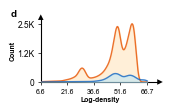

In [9]:


fig, ax = plot_similarity_distribution(
    gmm_pipeline=gmm_pipeline,
    df_embedding_fill=df_embedding_fill,
    df_abandon_filtered=df_abandon_filtered,
    features_no_coords=features_no_coords,
    save_path='figure/US_figure/similarity_standalone.png'
)
plt.show()

# 2、环境蜂窝图

现在需要绘制一个全美环境结构变量的蜂窝图，要求不同的蜂窝能够根据GMM打分体现不同的环境结构。

计算模块：
主要分为GMM评分与层次聚类计算模块、US蜂窝聚类生成模块、蜂窝图例映射模块

```模块一：US蜂窝聚类生成模块

数据接口：用xarray打开ds_all，其中的feature_groups所涉及变量是各个variable名称；蜂窝面积2500平方公里
计算执行：以各个蜂窝为单位，用Mean聚合各个variable
数据输出：feature_groups在各个蜂窝以Mean聚合生成的dataframe或者json，记为hex_groups_mean

```


```模块二：GMM评分与层次聚类模块

数据接口：导入gmm_model_34c_fixed.pkl模型，模块一生成的蜂窝数据结构
计算执行：第一，参照plot_abandon_component_probabilities的逻辑，根据输入的hex_groups_mean计算各个蜂窝的component概率$P(z_{k}|x_{i})$，并且根据Comonet to cluster maps聚合成Cluster的概率；第二，同时参照plot_gmm_component_patterns函数中feature_groups的模式条的计算方法，计算蜂窝内的样式条的比例
数据输出：各个蜂窝属于各个Cluster的概率、各个蜂窝的样式条比例

```


```模块三：蜂窝图例映射模块

数据接口：各个蜂窝属于各个Cluster的概率
计算执行：一共有4个Cluster，按照概率大小映射自定义的图例，在各个蜂窝内部填充对应的图例。
这个图例的内容主要包括两块设计组分
第一，圆心Cluster部分
在每个蜂窝的中心生成一个半径r的圆（r的大小约为蜂窝边长的1/3）
中间的圆心颜色代表了属于哪个Cluster的概率最大
第二，周围圆的pattern部分
记录圆心+半径r位置，在2r处生成圆形
各个圆形代表了各个feature_groups的贡献
数据输出：各个蜂窝所对应的图例

```



特征输入：
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    time ==2020-01-01

Comonet to cluster map：
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

GMM模型输入：
gmm_model_34c_fixed.pkl

包导入：
from function import *
C:\Dev\Landuse_Zhong_clean\function\gmm_training.py

## Load data

In [419]:
from function import *
from function.load_all_ds import load_all_ds
from function.gmm_training import CombinedPreprocessor  
import h3
import geopandas as gpd
import joblib
from shapely.geometry import Polygon, Point, box
from pyproj import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
ds_all = load_all_ds()
gmm_pipeline = joblib.load('gmm_model_23c_fixed.pkl')

# Load US shapefiles
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

print(f"ds_all shape: {ds_all.dims if hasattr(ds_all, 'dims') else 'N/A'}")
print(f"GMM model loaded: {gmm_pipeline}")

c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

ds_all shape: FrozenMappingWarningOnValuesAccess({'time': 31, 'lat': 21600, 'lon': 43200})
GMM model loaded: Pipeline(steps=[('preprocessor',
                 CombinedPreprocessor(categorical_features=['landcover'],
                                      numeric_features=['GDPpc', 'GDPtot',
                                                        'Population',
                                                        'Powerdist', 'DEM',
                                                        'Slope', 'GURdist',
                                                        'PrimaryRoad',
                                                        'SecondaryRoad',
                                                        'TertiaryRoad', 'tas',
                                                        'gdmp', 'rsds',
                                                        'wind'])),
                ('gmm',
                 GaussianMixture(covariance_type='diag', n_components=23,
                           

## Module 1: H3 Hexagonal Grid Generation and Data Aggregation


### H3库生成方案

In [ ]:
from tqdm.auto import tqdm

# Define feature groups
feature_groups = {
    'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
    'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
    'Geographic': ['DEM', 'Slope', 'gdmp'],
    'Climatic': ['rsds', 'tas', 'wind'],
}

# Get all variable names
all_vars = []
for group, vars_list in feature_groups.items():
    all_vars.extend(vars_list)


all_vars.append('landcover')
print(f"\nAll variables with landcover ({len(all_vars)}): {all_vars}")
print("Feature groups defined:")
for group, vars_list in feature_groups.items():
    print(f"  {group}: {vars_list}")
print(f"\nAll variables ({len(all_vars)}): {all_vars}")

# Check what's available in ds_all
print(f"\nds_all available variables: {list(ds_all.data_vars) if hasattr(ds_all, 'data_vars') else 'N/A'}")

def create_h3_hexagons_optimized(us_boundary, ds_all, time='2020-01-01', resolution=7,
                                 max_workers=8, parallel=True):
    """
    优化版：仅对美国本土(最大Polygon)做 H3 覆盖；对落入研究区的所有栅格点一次性取样并按 hex 聚合

    Parameters
    ----------
    us_boundary : GeoDataFrame 或 shapely (Multi)Polygon (EPSG:4326)
    ds_all      : xarray.Dataset，包含 all_vars 提到的变量
    time        : str，时间切片
    resolution  : int，H3 分辨率（7~8 常用）
    max_workers : int，并行线程数（用于大数据时的 H3 映射/几何）
    parallel    : bool，是否并行

    Returns
    -------
    GeoDataFrame[hex_id, variables..., geometry, center*, ...]  (EPSG:4326)
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Polygon, MultiPolygon, Point
    from shapely.ops import transform as shp_transform
    from concurrent.futures import ThreadPoolExecutor

    # ---------- H3 兼容导入 ----------
    try:
        import h3  # 可能是 v4
        _H3_V4 = hasattr(h3, "polyfill_geojson") or hasattr(h3, "polygon_to_cells") or hasattr(h3, "latlng_to_cell")
    except ImportError:
        h3 = None
        _H3_V4 = False

    try:
        from h3 import h3 as h3_legacy  # v3 旧接口
        _H3_V3 = True
    except ImportError:
        h3_legacy = None
        _H3_V3 = False

    if not (_H3_V4 or _H3_V3):
        raise ImportError("No usable H3 found. Install with `pip install h3`.")

    def _rings_of_polygon(poly: Polygon):
        # GeoJSON 需要 (lon, lat)
        ext = [(x, y) for x, y in poly.exterior.coords]
        holes = [[(x, y) for x, y in r.coords] for r in poly.interiors]
        return [ext] + holes

    def _geojson_coords(geom):
        if geom.geom_type == "Polygon":
            return _rings_of_polygon(geom)  # [ext, hole1, ...]
        elif geom.geom_type == "MultiPolygon":
            return [_rings_of_polygon(p) for p in geom.geoms]  # [[ext,...], [ext,...], ...]
        else:
            raise TypeError(f"Unsupported geometry type: {geom.geom_type}")

    # H3 封装：点 -> cell
    def H3_latlng_to_cell(lat, lon, res):
        if _H3_V4 and hasattr(h3, "latlng_to_cell"):
            return h3.latlng_to_cell(lat, lon, res)
        if _H3_V3 and hasattr(h3_legacy, "geo_to_h3"):
            return h3_legacy.geo_to_h3(lat, lon, res)
        raise RuntimeError("No latlng_to_cell / geo_to_h3 available in your H3.")

    # H3 封装：Polygon/MultiPolygon -> cells
    from shapely.geometry import mapping

    def H3_cover_from_geom(geom, res):
        """
        生成六边形覆盖，兼容 H3 v4 与 v3。
        - v4: 接受 GeoJSON dict（(lon,lat)）
        - v3: 接受环坐标列表（(lat,lon)），不接受 dict
        """
        # ---- v4 优先：polyfill_geojson / polygon_to_cells ----
        if _H3_V4:
            gj = mapping(geom)  # 标准 GeoJSON dict，坐标为 (lon,lat)
            # 有些 v4 只有其中一个函数，按可用性调用
            if hasattr(h3, "polyfill_geojson"):
                return set(h3.polyfill_geojson(gj, res))
            if hasattr(h3, "polygon_to_cells"):
                return set(h3.polygon_to_cells(gj, res))
            # 继续尝试 v3
            # (不要 raise，这里让它走到 v3 分支)
        
        # ---- v3：polyfill 需要 (lat,lon) 的环列表，不吃 dict ----
        if _H3_V3 and hasattr(h3_legacy, "polyfill"):
            def _rings_latlon(poly):
                # exterior + holes，且顺序转换为 (lat,lon)
                ext = [(y, x) for (x, y) in poly.exterior.coords]
                holes = [[(y, x) for (x, y) in r.coords] for r in poly.interiors]
                return [ext] + holes

            cells = set()
            if geom.geom_type == "Polygon":
                rings = _rings_latlon(geom)
                cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            elif geom.geom_type == "MultiPolygon":
                for p in geom.geoms:
                    rings = _rings_latlon(p)
                    cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            else:
                raise TypeError(f"Unsupported geometry type: {geom.geom_type}")
            return cells

        raise RuntimeError("No usable H3 cover function available (neither v4 polyfill_geojson/polygon_to_cells nor v3 polyfill).")


    # H3 封装：cell 边界 / 中心（统一输出 (lon,lat)，不传 geo_json=）
    def H3_cell_boundary_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_boundary"):
            coords = h3.cell_to_boundary(cell)  # 多数版本返 (lat, lon)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo_boundary"):
            coords = h3_legacy.h3_to_geo_boundary(cell)
        else:
            raise RuntimeError("No cell_to_boundary / h3_to_geo_boundary found.")
        return [(lon, lat) for (lat, lon) in coords]

    def H3_cell_center_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_latlng"):
            lat, lon = h3.cell_to_latlng(cell)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo"):
            lat, lon = h3_legacy.h3_to_geo(cell)
        else:
            raise RuntimeError("No cell_to_latlng / h3_to_geo found.")
        return (lon, lat)

    from pyproj import Transformer
    from shapely.geometry import shape

    print(f"\n=== 优化版：H3覆盖法生成六边形 (分辨率 {resolution}) ===")
    print("Step 1: 生成US区域的H3六边形覆盖...")

    # 统一获取几何
    us_geom = us_boundary.geometry.iloc[0] if isinstance(us_boundary, gpd.GeoDataFrame) else us_boundary

    # 修复几何
    try:
        from shapely.validation import make_valid
        us_geom = make_valid(us_geom)
    except Exception:
        us_geom = us_geom.buffer(0)

    # 只取最大 Polygon（在等面积投影下择优）
    if us_geom.geom_type == "MultiPolygon":
        print("  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...")
        fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True).transform
        areas = [shp_transform(fwd, p).area for p in us_geom.geoms]
        us_geom = list(us_geom.geoms)[int(np.argmax(areas))]
    elif us_geom.geom_type != "Polygon":
        raise ValueError(f"不支持的地理类型: {us_geom.geom_type}")

    print(f"  使用 Polygon，外环顶点数: {len(us_geom.exterior.coords)}")

    # 覆盖（严格 API 兼容）
    try:
        cells_list = list(H3_cover_from_geom(us_geom, resolution))
    except Exception as e:
        # 最后兜底：bbox 网格采样覆盖（尽量少用）
        print(f"  规范覆盖失败：{e}")
        print("  使用降级方案：bbox 采样覆盖 ...")
        minx, miny, maxx, maxy = us_geom.bounds
        step_deg = 0.25
        lon_samples = np.arange(minx, maxx, step_deg)
        lat_samples = np.arange(miny, maxy, step_deg)
        # contains_xy (Shapely 2) / vectorized.contains (<=1.8) 兼容
        try:
            from shapely import contains_xy
            def _inside(lon, lat): return contains_xy(us_geom, lon, lat)
        except Exception:
            from shapely.vectorized import contains as vcontains
            def _inside(lon, lat): return vcontains(us_geom, lon, lat)
        cells = set()
        for lat in lat_samples:
            for lon in lon_samples:
                if _inside(lon, lat):
                    try:
                        cells.add(H3_latlng_to_cell(lat, lon, resolution))
                    except Exception:
                        pass
        cells_list = list(cells)

    print(f"  生成了 {len(cells_list):,} 个六边形单元")

    # ---------- Step 2: 向量化统计（在研究区内的所有栅格点 -> hex -> groupby mean） ----------
    print("\nStep 2: 对研究区栅格点向量化取样，并按 hex 聚合...")

    # 选择时间切片
    ds_slice = ds_all.sel(time=time) if "time" in ds_all.coords else ds_all

    # 提取经纬度坐标
    if hasattr(ds_slice, 'lon') and hasattr(ds_slice, 'lat'):
        lons = np.asarray(ds_slice.lon.values)
        lats = np.asarray(ds_slice.lat.values)
    elif hasattr(ds_slice, 'longitude') and hasattr(ds_slice, 'latitude'):
        lons = np.asarray(ds_slice.longitude.values)
        lats = np.asarray(ds_slice.latitude.values)
    else:
        raise ValueError("Cannot find lon/lat coords in ds_all")

    # 这一步的操作是：
    # 首先根据美国本土的地理边界（us_geom）的坐标范围（bounding box），在只覆盖美国本土的经纬度范围内选取网格点，
    # 这样可以减少后续计算的数据量。具体来说：
    # - 如果经度和纬度是一维单调递增数组，则利用searchsorted方法精准截取只在美国本土范围内的经纬度（sub_lons, sub_lats），
    #   并用meshgrid生成笛卡尔网格xx, yy。
    # - 否则（例如经纬不是规则网格时），直接用所有经纬度生成meshgrid。
    minx, miny, maxx, maxy = us_geom.bounds
    if lons.ndim == 1 and lats.ndim == 1 and (np.all(np.diff(lons) >= 0) and np.all(np.diff(lats) >= 0)):
        i0 = max(0, np.searchsorted(lons, minx, side='left'))
        i1 = min(len(lons), np.searchsorted(lons, maxx, side='right'))
        j0 = max(0, np.searchsorted(lats, miny, side='left'))
        j1 = min(len(lats), np.searchsorted(lats, maxy, side='right'))
        sub_lons = lons[i0:i1]
        sub_lats = lats[j0:j1]
        xx, yy = np.meshgrid(sub_lons, sub_lats, indexing='xy')
    else:
        xx, yy = np.meshgrid(lons, lats, indexing='xy') if lons.ndim == 1 else (lons, lats)

    # 判断哪些经纬度点(xx, yy)落在us_geom表示的美国国界范围内，得到布尔mask
    # contains_xy / vectorized.contains 
    try:
        from shapely import contains_xy
        mask = contains_xy(us_geom, xx, yy)
    except Exception:
        from shapely.vectorized import contains as vcontains
        mask = vcontains(us_geom, xx, yy)

    xs = xx[mask].ravel()
    ys = yy[mask].ravel()
    print(f"  面内栅格点: {xs.size:,}")

    # 一次性插值所有变量（nearest）
    sampled = ds_slice[all_vars].interp(
        lon=('points', xs), lat=('points', ys), method='nearest'
    ).to_array('variable')  # (variable, points)

    data_matrix = sampled.transpose('points', 'variable').values  # ndarray
    var_names = sampled['variable'].values

    # 点 -> hex（可并行）
    def _map_chunk(idx):
        return [H3_latlng_to_cell(ys[i], xs[i], resolution) for i in idx]

    if parallel and xs.size > 50_000:
        chunks = np.array_split(np.arange(xs.size), max_workers)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            parts = list(ex.map(_map_chunk, chunks))
        hex_ids = np.fromiter((h for p in parts for h in p), dtype=object, count=xs.size)
    else:
        hex_ids = np.fromiter((H3_latlng_to_cell(lat, lon, resolution) for lon, lat in zip(xs, ys)),
                              dtype=object, count=xs.size)

    # 只保留在覆盖集中的 hex
    cover_set = set(cells_list)
    keep = np.fromiter((h in cover_set for h in hex_ids), dtype=bool, count=hex_ids.size)
    hex_ids = hex_ids[keep]
    data_matrix = data_matrix[keep, :]

    # 在聚合部分（第279-294行）替换为：

    numeric_vars = [v for v in var_names if v != 'landcover']
    categorical_vars = ['landcover'] if 'landcover' in var_names else []

    # 自定义聚合函数
    def q75_no_zero(x):
        """计算非零值的75%分位数"""
        clean_x = x[x > 0]
        if len(clean_x) == 0:
            return 0
        return np.percentile(clean_x, 75)

    agg_dict = {var: 'mean' for var in numeric_vars}

    # Powerdist和GURdist使用75%分位数（去除0值）
    if 'Population' in numeric_vars:
        agg_dict['Population'] = q75_no_zero
    if 'GDPpc' in numeric_vars:
        agg_dict['GDPpc'] = q75_no_zero
    if 'GDPtot' in numeric_vars:
        agg_dict['GDPtot'] = q75_no_zero
    if 'GURdist' in numeric_vars:
        agg_dict['GURdist'] = q75_no_zero   

    if categorical_vars:
        agg_dict.update({var: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] 
                    for var in categorical_vars})

    # 聚合
    df_points = pd.DataFrame(data_matrix, columns=var_names)
    df_points['hex_id'] = hex_ids


    df_hex = df_points.groupby('hex_id', sort=False, observed=True).agg(agg_dict).reset_index()


    print(f"\n  聚合得到 hex 数量: {len(df_hex):,}")

    # ---------- Step 3: 构造几何（可并行） ----------
    print("\nStep 3: 构造六边形几何与中心点 ...")

    def _geom_center(hid):
        ring = H3_cell_boundary_lonlat(hid)  # (lon,lat)
        poly = Polygon(ring)
        cx, cy = H3_cell_center_lonlat(hid)  # (lon,lat)
        return poly, Point(cx, cy), cy, cx

    ids = df_hex['hex_id'].tolist()
    if parallel and len(ids) > 3_000:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(_geom_center, ids))
    else:
        results = [_geom_center(h) for h in ids]

    geoms, centers, center_lats, center_lons = zip(*results)

    # 组装 GeoDataFrame
    out = df_hex.copy()
    out['geometry']   = list(geoms)
    out['center']     = list(centers)
    out['center_lat'] = center_lats
    out['center_lon'] = center_lons

    hex_gdf = gpd.GeoDataFrame(out, geometry='geometry', crs='EPSG:4326')
    if 'landcover' in hex_gdf.columns:
        hex_gdf['landcover'] = hex_gdf['landcover'].astype(int)

    # ---------- Step 4: 最近邻 hex 填补 ----------
    # H3 封装：返回以 cell 为中心、半径 k 的邻域
    def H3_k_ring(cell, k):
        if _H3_V4 and hasattr(h3, "grid_disk"):
            return h3.grid_disk(cell, k)
        if _H3_V3 and hasattr(h3_legacy, "k_ring"):
            return h3_legacy.k_ring(cell, k)
        raise RuntimeError("No grid_disk / k_ring function available in your H3 installation.")
        
    numeric_cols = [
        col for col in hex_gdf.columns
        if col not in {'hex_id', 'geometry', 'center', 'center_lat', 'center_lon', 'landcover'}
        and np.issubdtype(hex_gdf[col].dtype, np.number)
    ]
    categorical_cols = ['landcover'] if 'landcover' in hex_gdf.columns else []

    missing_mask = hex_gdf[numeric_cols + categorical_cols].isna().any(axis=1)
    if missing_mask.any():
        print(f"\nStep 4: 最近邻填补 {missing_mask.sum()} 个存在缺失的 hex ...")
        valid_hex_ids = set(hex_gdf.loc[~missing_mask, 'hex_id'])

        for idx in hex_gdf.index[missing_mask]:
            src_hex = hex_gdf.at[idx, 'hex_id']
            filled = False

            # 逐圈扩大邻域，最多搜索半径 5（可按需调节）
            for radius in range(1, 6):
                neighbors = H3_k_ring(src_hex, radius)
                for neighbor in neighbors:
                    if neighbor in valid_hex_ids:
                        donor = hex_gdf.loc[hex_gdf['hex_id'] == neighbor].iloc[0]
                        # 数值列直接覆盖；分类列用邻居的值
                        for col in numeric_cols:
                            if pd.isna(hex_gdf.at[idx, col]):
                                hex_gdf.at[idx, col] = donor[col]
                        for col in categorical_cols:
                            if pd.isna(hex_gdf.at[idx, col]):
                                hex_gdf.at[idx, col] = donor[col]
                        filled = True
                        break
                if filled:
                    break

            if not filled:
                print(f"  ⚠️ 无法为 hex {src_hex} 找到可用邻居（请检查覆盖范围或提高搜索半径）")
    else:
        print("\nStep 4: 未检测到缺失值，跳过最近邻填补。")

    

    print(f"\n✅ 成功创建 GeoDataFrame: {len(hex_gdf):,} 个六边形")

    return hex_gdf


# 创建六边形覆盖（使用优化方法）
hex_gdf_h4 = create_h3_hexagons_optimized(us_nation, ds_all, time='2020-01-01', resolution=4) 
hex_gdf_h3 = create_h3_hexagons_optimized(us_nation, ds_all, time='2020-01-01', resolution=3) 




All variables with landcover (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']


Feature groups defined:
  Socioeconomic: ['Population', 'GDPpc', 'GDPtot', 'GURdist']
  Infrastructure: ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
  Geographic: ['DEM', 'Slope', 'gdmp']
  Climatic: ['rsds', 'tas', 'wind']

All variables (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

ds_all available variables: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']

=== 优化版：H3覆盖法生成六边形 (分辨率 4) ===
Step 1: 生成US区域的H3六边形覆盖...
  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...
  使用 Polygon，外环顶点数: 15937
  规范覆盖失败：Unrecognized type: <class 'dict'>
  使用降级方案：bbox 采样覆盖 ...
  生成了 4,420 个六边形单元

Step 2: 对研究区栅格点向量化取样，并按 hex 聚合...


In [ ]:
# hex_gdf_h4.to_file("data/US_data/hex_gdf_H4.geojson", driver="GeoJSON")
# hex_gdf_h3.to_file("data/US_data/hex_gdf_H3.geojson", driver="GeoJSON")


### Hexgon生成方案

In [ ]:
from tqdm.auto import tqdm
import math  # 添加 math 模块

# Define feature groups
feature_groups = {
    'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
    'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
    'Geographic': ['DEM', 'Slope', 'gdmp'],
    'Climatic': ['rsds', 'tas', 'wind'],
}

# Get all variable names
all_vars = []
for group, vars_list in feature_groups.items():
    all_vars.extend(vars_list)

all_vars.append('landcover')
print(f"\nAll variables with landcover ({len(all_vars)}): {all_vars}")
print("Feature groups defined:")
for group, vars_list in feature_groups.items():
    print(f"  {group}: {vars_list}")
print(f"\nAll variables ({len(all_vars)}): {all_vars}")


def hex_grid_equal_area_axial(
    boundary_gdf, ds_all, time='2020-01-01',
    target_area_km2: float = 2500.0,
    orientation: str = "flat",
    draw_crs: str = "ESRI:102003",
    out_crs: str = "EPSG:4326",
    anchor_xy: tuple = (0.0, 0.0),
    rotation_deg: float = 0.0,
    clip: bool = True,              # 是否裁剪到研究区
    clip_type: str = "intersection", # 'intersection': 裁剪; 'full': 保留完整; 'oversized': 扩展bbox
    max_workers: int = 8,
    parallel: bool = True
) -> gpd.GeoDataFrame:
    """
    依据目标面积在等面积投影下生成规则六边形网格，并聚合栅格数据。
    引入 H3 方案的"最大几何体选择"和"向量化聚合"机制。
    
    Parameters
    ----------
    clip_type : str
        - 'intersection': 裁剪到研究区边界（默认，符合地理事实）
        - 'full': 保留完整六边形（类似 H3，所有部分覆盖的都保留）
        - 'oversized': 扩展 bbox 生成完整六边形（确保边界无裁剪）
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Polygon, Point
    from shapely.ops import transform as shp_transform
    from pyproj import Transformer
    from shapely.validation import make_valid
    from shapely.ops import unary_union
    from concurrent.futures import ThreadPoolExecutor
    
    print(f"\n=== 自定义面积六边形网格 (目标: {target_area_km2} km²) ===")
    
    # ---------- 1) 投影到等面积并做几何修复 ----------
    g_draw = boundary_gdf.to_crs(draw_crs).copy()
    geom = unary_union(g_draw.geometry)
    try:
        geom = make_valid(geom)
    except Exception:
        geom = geom.buffer(0)
    
    # ---------- 2) 最大几何体选择（复用 H3 逻辑）----------
    if geom.geom_type == "MultiPolygon":
        print("  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...")
        # 直接在 draw_crs 下计算面积（已经等面积投影）
        areas = [p.area for p in geom.geoms]
        geom = list(geom.geoms)[int(np.argmax(areas))]
    elif geom.geom_type != "Polygon":
        raise ValueError(f"不支持的地理类型: {geom.geom_type}")
    
    print(f"  使用 Polygon，外环顶点数: {len(geom.exterior.coords)}")
    
    xmin, ymin, xmax, ymax = geom.bounds
    
    # ---------- 3) 目标面积 -> 六边形边长 size ----------
    A = float(target_area_km2) * 1e6  # m²
    R = math.sqrt((2.0 * A) / (3.0 * math.sqrt(3.0)))  # meters
    print(f"  六边形边长: {R:.2f} m")
    
    # ---------- 4) axial 坐标公式（避免错缝） ----------
    if orientation.lower() == "flat":
        dx = 1.5 * R
        dy = math.sqrt(3.0) * R
        axial_to_xy = lambda q, r: (
            anchor_xy[0] + R * 1.5 * q,
            anchor_xy[1] + R * math.sqrt(3.0) * (r + 0.5 * (q & 1))
        )
        base_angles = np.array([0, 60, 120, 180, 240, 300], dtype=float)
    elif orientation.lower() == "pointy":
        dx = math.sqrt(3.0) * R
        dy = 1.5 * R
        axial_to_xy = lambda q, r: (
            anchor_xy[0] + R * math.sqrt(3.0) * (q + 0.5 * (r & 1)),
            anchor_xy[1] + R * 1.5 * r
        )
        base_angles = np.array([30, 90, 150, 210, 270, 330], dtype=float)
    else:
        raise ValueError("orientation must be 'flat' or 'pointy'")
    
    angles = np.deg2rad(base_angles + float(rotation_deg))
    
    # ---------- 5) 计算 q,r 索引范围 ----------
    pad = 2
    q_min = math.floor((xmin - anchor_xy[0]) / (dx)) - pad
    q_max = math.ceil((xmax - anchor_xy[0]) / (dx)) + pad
    r_min = math.floor((ymin - anchor_xy[1]) / (dy)) - pad
    r_max = math.ceil((ymax - anchor_xy[1]) / (dy)) + pad
    
    # ---------- 6) 生成网格 ----------
    polys = []
    hex_id_list = []
    
    if clip_type == "oversized":
        # 方案3：扩展 bbox，确保边界外的完整六边形也被包含
        from shapely.geometry import box
        expanded_bbox = box(xmin - R*2, ymin - R*2, xmax + R*2, ymax + R*2)
        clip_geom = expanded_bbox  # 使用扩展边界
    else:
        clip_geom = geom  # 使用原始研究区边界
    
    for q in range(q_min, q_max + 1):
        for r in range(r_min, r_max + 1):
            cx, cy = axial_to_xy(q, r)
            verts = [(cx + R * math.cos(t), cy + R * math.sin(t)) for t in angles]
            poly = Polygon(verts)
            
            if clip:
                if clip_type == "full":
                    # 方案2：类似 H3，只要相交就保留完整六边形
                    if poly.intersects(clip_geom):
                        polys.append(poly)  # 保留完整六边形
                        hex_id_list.append(f"hex_{q}_{r}")
                else:
                    # 方案1：裁剪到边界
                    if not poly.intersects(clip_geom):
                        continue
                    poly = poly.intersection(clip_geom)
                    if poly.is_empty:
                        continue
                    polys.append(poly)
                    hex_id_list.append(f"hex_{q}_{r}")
            else:
                polys.append(poly)
                hex_id_list.append(f"hex_{q}_{r}")
    
    print(f"  生成 {len(polys)} 个六边形 (clip_type={clip_type})")
    
    # ---------- 7) 组装 GDF & 转回 EPSG:4326 ----------
    hex_gdf_albers = gpd.GeoDataFrame(
        {'hex_id': hex_id_list}, geometry=polys, crs=draw_crs
    )
    
    hex_gdf_4326 = hex_gdf_albers.to_crs(out_crs)
    # 正确：在投影坐标系计算centroid再转换
    hex_gdf_4326['center_lat'] = hex_gdf_albers.geometry.centroid.y  # 已在 Albers 投影下
    hex_gdf_4326['center_lon'] = hex_gdf_albers.geometry.centroid.x
    hex_gdf_4326['center'] = [Point(lon, lat) for lon, lat in zip(hex_gdf_4326['center_lon'], hex_gdf_4326['center_lat'])]
    
    # ---------- 8) 向量化聚合栅格数据（复用 H3 逻辑）----------
    print("\nStep 2: 对研究区栅格点向量化取样，并按 hex 聚合...")
    
    ds_slice = ds_all.sel(time=time) if "time" in ds_all.coords else ds_all
    
    if hasattr(ds_slice, 'lon') and hasattr(ds_slice, 'lat'):
        lons = np.asarray(ds_slice.lon.values)
        lats = np.asarray(ds_slice.lat.values)
    elif hasattr(ds_slice, 'longitude') and hasattr(ds_slice, 'latitude'):
        lons = np.asarray(ds_slice.longitude.values)
        lats = np.asarray(ds_slice.latitude.values)
    else:
        raise ValueError("Cannot find lon/lat coords in ds_all")
    
    # 在美国本土 bbox 内裁剪栅格（H3 优化）
    # 先将边界转回 EPSG:4326 用于裁剪
    boundary_4326 = boundary_gdf.to_crs(out_crs) if boundary_gdf.crs != out_crs else boundary_gdf
    geom_4326 = unary_union(boundary_4326.geometry)
    try:
        geom_4326 = make_valid(geom_4326)
    except Exception:
        geom_4326 = geom_4326.buffer(0)
    
    # 只在美国本土 bbox 内构网格，再精筛到面内
    minx, miny, maxx, maxy = geom_4326.bounds
    if lons.ndim == 1 and lats.ndim == 1 and (np.all(np.diff(lons)>=0) and np.all(np.diff(lats)>=0)):
        i0 = max(0, np.searchsorted(lons, minx, side='left'))
        i1 = min(len(lons), np.searchsorted(lons, maxx, side='right'))
        j0 = max(0, np.searchsorted(lats, miny, side='left'))
        j1 = min(len(lats), np.searchsorted(lats, maxy, side='right'))
        sub_lons = lons[i0:i1]
        sub_lats = lats[j0:j1]
        xx, yy = np.meshgrid(sub_lons, sub_lats, indexing='xy')
    else:
        xx, yy = np.meshgrid(lons, lats, indexing='xy') if lons.ndim==1 else (lons, lats)
    
    # contains_xy / vectorized.contains 兼容（H3 优化）
    try:
        from shapely import contains_xy
        mask = contains_xy(geom_4326, xx, yy)
    except Exception:
        from shapely.vectorized import contains as vcontains
        mask = vcontains(geom_4326, xx, yy)
    
    xs = xx[mask].ravel()
    ys = yy[mask].ravel()
    print(f"  面内栅格点: {xs.size:,}")
    
    # 一次性插值所有变量（nearest）- H3 向量化方法
    sampled = ds_slice[all_vars].interp(
        lon=('points', xs), lat=('points', ys), method='nearest'
    ).to_array('variable')  # (variable, points)
    
    data_matrix = sampled.transpose('points', 'variable').values  # ndarray
    var_names = sampled['variable'].values
    
    # 向量化判断点是否在六边形内（并行优化）
    def _assign_points_to_hexes_parallel(xx_flat, yy_flat, hex_gdf_albers_calc):
        points_gdf = gpd.GeoDataFrame(
            geometry=[Point(lon, lat) for lon, lat in zip(xx_flat, yy_flat)],
            crs=out_crs
        ).to_crs(draw_crs)
        
        # 空间连接
        joined = gpd.sjoin(points_gdf, hex_gdf_albers_calc[['hex_id', 'geometry']], 
                          how='inner', predicate='within')
        return joined
    
    hex_gdf_albers_for_sjoin = hex_gdf_albers.copy()
    
    if parallel and xs.size > 50_000:
        chunks = np.array_split(np.arange(xs.size), max_workers)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            joined_parts = list(ex.map(
                lambda idxs: _assign_points_to_hexes_parallel(xs[idxs], ys[idxs], hex_gdf_albers_for_sjoin),
                chunks
            ))
        joined_full = pd.concat(joined_parts, ignore_index=True)
    else:
        joined_full = _assign_points_to_hexes_parallel(xs, ys, hex_gdf_albers_for_sjoin)
    
    # 获取匹配的栅格数据索引
    # 注意：joined_full.index 是原始 points_gdf 的索引，不是 matched_indices
    # 需要重新映射
    point_grid_idx = np.arange(xs.size)  # 0 to xs.size-1
    matched_point_idx = joined_full.index.values  # 在 joined_full 中的索引
    matched_hex_ids = joined_full['hex_id'].values
    
    # 对应到 data_matrix 的行索引
    data_matrix_filtered = data_matrix[matched_point_idx, :]
    
    # ---------- 9) 聚合（H3 自定义策略）----------
    numeric_vars = [v for v in var_names if v != 'landcover']
    categorical_vars = ['landcover'] if 'landcover' in var_names else []
    
    agg_dict = {var: 'mean' for var in numeric_vars}


    # 特征增强
    if 'Population' in numeric_vars:
        agg_dict['Population'] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    if 'GDPpc' in numeric_vars:
        agg_dict['GDPpc'] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    if 'GDPtot' in numeric_vars:
        agg_dict['GDPtot'] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    if 'GURdist' in numeric_vars:
        agg_dict['GURdist'] = lambda x: np.percentile(x[x > 0], 25) if np.any(x > 0) else 0
    if 'Population' in numeric_vars:
        agg_dict['gdmp'] = lambda x: np.percentile(x[x > 0], 25) if np.any(x > 0) else 0
    infrastructure_vars = ['PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
    for var in infrastructure_vars:
        if var in numeric_vars:
            agg_dict[var] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    
    if categorical_vars:
        agg_dict.update({var: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] 
                        for var in categorical_vars})
    
    df_points = pd.DataFrame(data_matrix_filtered, columns=var_names)
    df_points['hex_id'] = matched_hex_ids
    
    df_hex = df_points.groupby('hex_id', sort=False, observed=True).agg(agg_dict).reset_index()
    
    print(f"  聚合得到 {len(df_hex)} 个六边形")
    
    # ---------- 10) 合并 ----------
    hex_gdf_final = hex_gdf_4326.merge(df_hex, on='hex_id', how='right')
    
    # 添加面积字段
    hex_gdf_final['area_m2'] = hex_gdf_final.to_crs(draw_crs).geometry.area
    hex_gdf_final['area_km2'] = hex_gdf_final['area_m2'] / 1e6
    
    print(f"\n✅ 成功创建 GeoDataFrame: {len(hex_gdf_final)} 个六边形")
    
    return hex_gdf_final


# 使用示例
hex_gdf_full_3500 = hex_grid_equal_area_axial(
    boundary_gdf=us_nation, ds_all=ds_all, time='2020-01-01',
    target_area_km2=4500.0, clip_type="full"
)



All variables with landcover (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']
Feature groups defined:
  Socioeconomic: ['Population', 'GDPpc', 'GDPtot', 'GURdist']
  Infrastructure: ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
  Geographic: ['DEM', 'Slope', 'gdmp']
  Climatic: ['rsds', 'tas', 'wind']

All variables (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

=== 自定义面积六边形网格 (目标: 4500.0 km²) ===
  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...
  使用 Polygon，外环顶点数: 15937
  六边形边长: 41617.91 m
  生成 1914 个六边形 (clip_type=full)

Step 2: 对研究区栅格点向量化取样，并按 hex 聚合...
  面内栅格点: 15,920,728
  聚合得到 1911 个六边形

✅ 成功创建 GeoDataFrame: 1911 个六边形


In [ ]:

# 检测缺失值并用最近邻填充，并保存

from sklearn.impute import KNNImputer

# 仅对数值型字段进行最近邻填充
numeric_cols = hex_gdf_full_3500.select_dtypes(include=['float64', 'int64']).columns
cols_to_impute = [col for col in numeric_cols if col not in ['hex_id']]

values = hex_gdf_full_3500[cols_to_impute].values

if np.any(pd.isnull(values)):
    imputer = KNNImputer(n_neighbors=3)
    filled_values = imputer.fit_transform(values)
    hex_gdf_full_3500[cols_to_impute] = filled_values
    print("已用最近邻填充缺失值")
else:
    print("数据未检测到缺失值，无需填充")

# 保存填充后的数据
hex_gdf_full_3500.to_file('data/US_data/hex_gdf_4500.geojson', driver="GeoJSON")
print("已保存填充后的数据：hex_gdf_2500.geojson")



数据未检测到缺失值，无需填充
已保存填充后的数据：hex_gdf_2500.geojson


<Axes: >

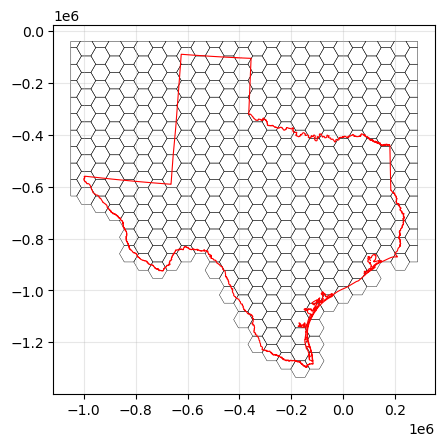

In [ ]:
# 局部放大：以美国疆域为基础，缩小bbox尺寸 (如Texas)

us_states_proj = us_states.to_crs("ESRI:102003")
state_name = "Texas"
texas_geom = us_states_proj[us_states_proj["NAME"] == state_name].geometry.iloc[0]

# 生成更小bbox（可适当buffer扩大一点视野范围）
texas_bbox = texas_geom.bounds
buffer_m = 50000  # 例如，四周各扩展50公里
minx, miny, maxx, maxy = texas_bbox
texas_bbox_polygon = box(minx-buffer_m, miny-buffer_m, maxx+buffer_m, maxy+buffer_m)

# 投影hex到相同坐标系
hex_proj = hex_gdf_full_3500.to_crs("ESRI:102003")

# 按texas_bbox裁剪
hex_clipped = gpd.clip(hex_proj, texas_bbox_polygon)

# 可视化
ax = hex_clipped.plot(edgecolor="k", facecolor="none", linewidth=0.3)
gpd.GeoSeries(texas_geom).boundary.plot(ax=ax, color="red", linewidth=0.8)


## Module 2: GMM Scoring and Cluster Assignment


样本 x
    ↓
logdensity(x) = log p(x)  [全局拟合度]
    ↓
component_probs = P(z_k | x)  [Component归属概率]
    ↓
hex_pattern_scores = component_probs @ component_pattern_matrix  [Pattern贡献]

In [18]:
%matplotlib inline
from function import *
import geopandas as gpd
from function.gmm_training import CombinedPreprocessor 
from shapely.geometry import Polygon, Point, box
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import geopandas as gpd
import h3

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped



# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_abandon = df_abandon[
    (df_abandon['lon'] >= usa_bounds_main['lon_min']) &
    (df_abandon['lon'] <= usa_bounds_main['lon_max']) &
    (df_abandon['lat'] >= usa_bounds_main['lat_min']) &
    (df_abandon['lat'] <= usa_bounds_main['lat_max'])
]
# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_nation)
df_embedding = clip_data_with_us_states(df_embedding, us_nation)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)


# hex_gdf_h4 = gpd.read_file("data/US_data/hex_gdf_H4.geojson")
# hex_gdf_h4 = gpd.read_file("data/US_data/hex_gdf_H3.geojson")
# hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_2500.geojson')
# hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_3500.geojson')
# hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_4000.geojson')

hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_4500.geojson')
gmm_pipeline = joblib.load('gmm_model_23c_fixed.pkl')



You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


In [19]:
import joblib
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import geopandas as gpd
from shapely.geometry import Point

def calculate_cluster_probabilities(df, gmm_pipeline, distance_threshold=1.5):
    """
    Calculate cluster probabilities using dynamic hierarchical clustering.
    
    Parameters
    ----------
    df : pd.DataFrame or gpd.GeoDataFrame
        输入数据框（应该是训练数据或与训练数据相同分布的数据）
    gmm_pipeline : Pipeline
        GMM模型管道
    distance_threshold : float
        层次聚类距离阈值，默认1.5（必须与plot_gmm_component_patterns一致）
    
    Returns
    -------
    cluster_probs : np.ndarray
        Cluster概率矩阵 (n_samples, n_clusters)，列顺序按cluster_id排序
    component_prob_df : pd.DataFrame
        Component概率DataFrame
    cluster_prob_df : pd.DataFrame
        Cluster概率DataFrame，列名为cluster_1, cluster_2, ...
    df : pd.DataFrame or gpd.GeoDataFrame
        添加了component_probs, cluster_probs, dominant_cluster, log_density列的输入数据框
        dominant_cluster使用原始cluster_id（1, 2, 3, ...），而不是索引
    """
    print("\n=== Calculating Cluster Probabilities ===")
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    means = gmm.means_
    n_components = gmm.n_components
    
    # 动态层次聚类（与plot_gmm_component_patterns完全一致）
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    print(f"模型特征信息：")
    print(f"  Numeric features: {numeric_features}")
    print(f"  Categorical features: {categorical_features}")
    
    # 构建component_features_std（与plot_gmm_component_patterns完全一致）
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        
        # 获取每个component的dominant landcover类别（0-based索引）
        dominant_landcover_indices = np.argmax(landcover_means, axis=1)  # shape: (n_components,)
        
        # 将索引转换为1-based的类别编号（1-9）
        dominant_landcover_classes = dominant_landcover_indices + 1
        
        # 定义landcover重新编码规则（与plot_gmm_component_patterns一致）
        landcover_to_pattern = {
            1: ['Socioeconomic'], 2: ['Geographic'], 3: ['Geographic'],
            4: ['Geographic'], 5: ['Geographic'], 6: ['Climatic'],
            7: ['Socioeconomic', 'Infrastructure'], 8: ['Geographic'], 9: ['Climatic'],
        }
        
        def encode_landcover_by_pattern(lc_class, lc_to_pattern_map):
            """根据landcover类别和pattern映射进行重新编码
            Socioeconomic/Infrastructure → +1.5（较大正数）
            Geographic → -1.5（较小负数）
            Climatic → 0.0（中间值）
            """
            if lc_class not in lc_to_pattern_map:
                return 0.0
            
            patterns = lc_to_pattern_map[lc_class]
            encoding_values = []
            for pattern in patterns:
                if pattern in ['Socioeconomic', 'Infrastructure']:
                    encoding_values.append(1.5)
                elif pattern == 'Geographic':
                    encoding_values.append(-1.5)
                elif pattern == 'Climatic':
                    encoding_values.append(0.0)
            
            return np.mean(encoding_values) if encoding_values else 0.0
        
        # 对每个component的dominant landcover进行重新编码
        landcover_encoded_values = np.array([
            encode_landcover_by_pattern(lc_class, landcover_to_pattern) 
            for lc_class in dominant_landcover_classes
        ])
        
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            landcover_encoded_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    # 层次聚类（与plot_gmm_component_patterns完全一致）
    # 只使用numeric特征进行聚类，排除landcover
    # component_features_std包含landcover用于显示，但聚类时只用numeric特征
    # component_features_for_clustering = means[:, :n_numeric]  # 只用numeric特征
    # distance_matrix = pdist(component_features_for_clustering, metric='correlation')
    # linkage_matrix = linkage(distance_matrix, method='ward')
    # cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    # print(f"\n=== 层次聚类信息 ===")
    # print(f"聚类使用的特征数量: {n_numeric} (仅numeric特征，排除landcover)")
    # print(f"实际聚类数量: {len(set(cluster_labels))}")
    # ========== 层次聚类 ==========
    # 使用numeric特征 + 完整的landcover概率分布进行聚类
    if categorical_features:
        # 包含完整的landcover概率分布（保留所有类别的信息）
        component_features_for_clustering = np.column_stack([
            means[:, :n_numeric],      # numeric特征
            means[:, n_numeric:]        # 完整的landcover概率分布（所有类别）
        ])
        n_features_for_clustering = n_numeric + means[:, n_numeric:].shape[1]
        print(f"\n=== 层次聚类信息 ===")
        print(f"聚类使用的特征数量: {n_features_for_clustering} (numeric: {n_numeric} + landcover: {means[:, n_numeric:].shape[1]})")
    else:
        # 如果没有categorical特征，只使用numeric特征
        component_features_for_clustering = means[:, :n_numeric]
        n_features_for_clustering = n_numeric
        print(f"\n=== 层次聚类信息 ===")
        print(f"聚类使用的特征数量: {n_numeric} (仅numeric特征，无landcover)")

    distance_matrix = pdist(component_features_for_clustering, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=1.5, criterion='distance')
    print(f"实际聚类数量: {len(set(cluster_labels))}")
    # 构建动态映射（按cluster_id排序，确保顺序一致）
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    # 按cluster_id排序，确保顺序一致
    sorted_cluster_ids = sorted(clusters_dict.keys())
    
    print(f"\n动态生成的聚类映射（按cluster_id排序）:")
    for cluster_id in sorted_cluster_ids:
        components = clusters_dict[cluster_id]
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # 关键：按照模型期望的features顺序排列列
    features_in_order = numeric_features + categorical_features
        
    # 检查所有需要的特征是否都在df中
    print(f"\n=== 特征完整性检查 ===")
    missing_features = [f for f in features_in_order if f not in df.columns]
    if missing_features:
        print(f"⚠️ 以下特征在df中不存在: {missing_features}")
        raise ValueError(f"缺少必需的特征列: {missing_features}")
    
    # 数据质量检查
    print(f"\n=== 数据质量检查 ===")
    print(f"数据统计（前5个特征）:")
    for feat in features_in_order[:5]:
        if feat in df.columns:
            col_data = df[feat]
            print(f"  {feat}: "
                  f"min={col_data.min():.2f}, "
                  f"max={col_data.max():.2f}, "
                  f"mean={col_data.mean():.2f}, "
                  f"NaN={col_data.isna().sum()}")
    
    # 检查缺失值
    data_for_transformation = df[features_in_order]
    missing_counts = data_for_transformation.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"\n⚠️ 发现缺失值:")
        for col in missing_counts[missing_counts > 0].index:
            count = missing_counts[col]
            print(f"  {col}: {count} 缺失 (占比 {100*count/len(df):.2f}%)")
    else:
        print(f"\n✅ 所有特征列均无缺失值")
    
    # 检查无穷值
    numeric_existing = [f for f in numeric_features if f in df.columns]
    if numeric_existing:
        inf_counts = np.isinf(data_for_transformation[numeric_existing]).sum()
        if inf_counts.sum() > 0:
            print(f"\n⚠️ 发现无穷值:")
            for col in inf_counts[inf_counts > 0].index:
                print(f"  {col}: {inf_counts[col]} 无穷值")
        else:
            print(f"\n✅ 所有数值特征均无无穷值")
    
    # 数据变换和GMM评分
    X_transformed = preprocessor.transform(df[features_in_order])
    
    # 计算log_density（对数概率密度）
    log_density = gmm.score_samples(X_transformed)
    print(f"\nLog-density统计:")
    print(f"  mean={np.mean(log_density):.3f}, std={np.std(log_density):.3f}")
    print(f"  min={np.min(log_density):.3f}, max={np.max(log_density):.3f}")
    
    # 计算component概率
    component_probs = gmm.predict_proba(X_transformed)
    
    print(f"\nComponent probabilities shape: {component_probs.shape}")
    
    # 详细统计各component的概率
    print("\n=== Component Probability Statistics ===")
    comp_means = component_probs.mean(axis=0)
    comp_max = component_probs.max(axis=0)
    comp_min = component_probs.min(axis=0)
    comp_dominant_counts = (np.argmax(component_probs, axis=1).reshape(-1,1) == np.arange(n_components)).sum(axis=0)

    component_columns = [f"component_{i}" for i in range(n_components)]
    component_prob_df = pd.DataFrame(component_probs, columns=component_columns, index=df.index)
    
    # 显示前10个和后10个component的统计
    print("Top 10 components by average probability:")
    top_comps = np.argsort(comp_means)[-10:][::-1]
    for comp_idx in top_comps:
        if comp_means[comp_idx] > 0:
            print(f"Component {comp_idx}: mean={comp_means[comp_idx]:.4f}, "
                  f"max={comp_max[comp_idx]:.4f}, "
                  f"min={comp_min[comp_idx]:.4f}, "
                  f"dominant={comp_dominant_counts[comp_idx]}")
    
    n_samples = len(df)
    
    # ========== 修复：按cluster_id排序聚合 ==========
    n_clusters = len(sorted_cluster_ids)
    cluster_probs = np.zeros((n_samples, n_clusters))
    
    # 创建cluster_id到数组索引的映射
    cluster_id_to_idx = {cluster_id: idx for idx, cluster_id in enumerate(sorted_cluster_ids)}
    cluster_idx_to_id = {idx: cluster_id for cluster_id, idx in cluster_id_to_idx.items()}
    
    # 按排序后的cluster_id顺序聚合
    for cluster_idx, cluster_id in enumerate(sorted_cluster_ids):
        components = clusters_dict[cluster_id]
        # 对属于该cluster的所有components的概率求和
        cluster_probs[:, cluster_idx] = component_probs[:, components].sum(axis=1)
    
    # DataFrame列名使用原始cluster_id
    cluster_columns = [f"cluster_{cid}" for cid in sorted_cluster_ids]
    cluster_prob_df = pd.DataFrame(cluster_probs, columns=cluster_columns, index=df.index)
    
    # Cluster概率统计
    print(f"\n=== Cluster Probability Statistics ===")
    print(f"Cluster probabilities shape: {cluster_probs.shape}")
    
    # ========== 关键修复：使用概率均值（软分配）而不是argmax计数 ==========
    # 这是正确的GMM方法：使用概率均值（软分配）
    cluster_prob_means = cluster_probs.mean(axis=0)  # 每个cluster的平均概率
    
    # 硬分配（用于dominant_cluster，但不是统计百分比的方法）
    dominant_cluster_indices = cluster_probs.argmax(axis=1)  # 这是数组索引（0-based）
    dominant_cluster_ids = np.array([cluster_idx_to_id[idx] for idx in dominant_cluster_indices])
    
    for cluster_idx in range(n_clusters):
        cluster_id = cluster_idx_to_id[cluster_idx]
        # 软分配（概率均值）- 这是正确的GMM方法
        mean_prob = cluster_prob_means[cluster_idx]
        # 硬分配（argmax计数）- 仅用于dominant_cluster，不是统计百分比
        hard_count = (dominant_cluster_indices == cluster_idx).sum()
        hard_pct = 100 * hard_count / n_samples
        
        print(f"Cluster {cluster_id}:")
        print(f"  Mean probability (soft, correct): {mean_prob:.4f} ({mean_prob*100:.2f}%)")
        print(f"  Hard assignment count: {hard_count} ({hard_pct:.2f}%)")
    
    # 将结果添加到DataFrame中
    df = df.copy()  # 避免修改原始DataFrame
    df['component_probs'] = list(component_prob_df.values.tolist())
    df['cluster_probs'] = list(cluster_prob_df.values.tolist())
    df['dominant_cluster'] = dominant_cluster_ids  
    df['log_density'] = log_density
    
    # ========== 返回cluster的百分比信息（用于与plot_gmm_component_patterns对齐）==========
    cluster_percentages = {}
    for cluster_idx in range(n_clusters):
        cluster_id = cluster_idx_to_id[cluster_idx]
        # 使用概率均值（软分配）作为百分比 - 这是正确的GMM方法
        cluster_percentages[cluster_id] = cluster_prob_means[cluster_idx] * 100
    
    print(f"\n=== Cluster Percentages (Soft Assignment - Correct Method) ===")
    print("These percentages should match plot_gmm_component_patterns if using the same data:")
    for cluster_id in sorted_cluster_ids:
        print(f"  Cluster {cluster_id}: {cluster_percentages[cluster_id]:.2f}%")
    
    return cluster_probs, component_prob_df, cluster_prob_df, df


cluster_probs, component_prob_df,cluster_prob_df,hex_gdf_h4= calculate_cluster_probabilities(hex_gdf_h4, gmm_pipeline)
cluster_probs_pv, component_prob_pv, cluster_prob_pv, pv_pattern = calculate_cluster_probabilities(df_embedding_fill, gmm_pipeline)
cluster_probs_ab, component_prob_ab, cluster_prob_ab, ab_pattern = calculate_cluster_probabilities(df_abandon_filtered, gmm_pipeline)




=== Calculating Cluster Probabilities ===
模型特征信息：
  Numeric features: ['GDPpc', 'GDPtot', 'Population', 'Powerdist', 'DEM', 'Slope', 'GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'tas', 'gdmp', 'rsds', 'wind']
  Categorical features: ['landcover']

=== 层次聚类信息 ===
聚类使用的特征数量: 23 (numeric: 14 + landcover: 9)
实际聚类数量: 3

动态生成的聚类映射（按cluster_id排序）:
  Cluster 1: Components [1, 4, 7, 10, 13, 15, 17]
  Cluster 2: Components [0, 5, 6, 12, 14, 18, 22]
  Cluster 3: Components [2, 3, 8, 9, 11, 16, 19, 20, 21]

=== 特征完整性检查 ===

=== 数据质量检查 ===
数据统计（前5个特征）:
  GDPpc: min=21802.00, max=136851.00, mean=51775.51, NaN=0
  GDPtot: min=0.00, max=132888676.00, mean=1971088.79, NaN=0
  Population: min=0.00, max=2343.15, mean=24.34, NaN=0
  Powerdist: min=782.83, max=3635954.60, mean=20201.70, NaN=0
  DEM: min=13.41, max=2804.15, mean=773.75, NaN=0

✅ 所有特征列均无缺失值

✅ 所有数值特征均无无穷值

Log-density统计:
  mean=-485.128, std=9006.646
  min=-312602.423, max=66.007

Component probabilities shape: (1911, 23)

===

In [20]:
df_abandon_fill

,lat,lon,time,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,gdmp,GDPpc,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
235,33.595833,-117.587500,2020-01-01,1996.0,27.0,1,6.0,212.7500,75.133736,70361.0,...,NaN,703.357400,780.78986,30.645251,19.501024,29.481208,3.900984,2904.658306,278.743995,1.375530
236,33.629166,-117.579170,2020-01-01,1996.0,27.0,1,6.0,285.3750,68.167511,70361.0,...,NaN,323.802300,780.78986,30.645251,19.551126,29.481208,3.352981,2903.394378,278.743995,1.528333
237,33.720833,-117.737500,2020-01-01,2007.0,16.0,1,2.0,129.5625,74.410530,70361.0,...,NaN,31.323376,1104.20360,246.489866,19.494038,91.763334,4.064891,2905.660982,1274.357385,2.088464
238,33.904167,-117.820830,2020-01-01,2001.0,22.0,1,6.0,156.5000,53.003113,70361.0,...,NaN,860.799700,780.78986,120.163278,19.662483,66.284086,3.566216,2908.213964,1225.980459,1.605897
239,33.920834,-117.620834,2020-01-01,2018.0,5.0,1,2.0,160.0000,120.641510,45655.0,...,NaN,1.989241,1745.89920,98.867925,19.486841,27.764742,0.559695,2913.508335,324.932328,2.371819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72071,47.262500,-68.379166,2020-01-01,1996.0,27.0,1,2.0,269.7500,69.684128,33949.0,...,NaN,5.105907,780.78986,49.859261,12.318412,1.558921,4.100901,2763.957254,150.075090,3.005180
72072,47.262500,-68.370834,2020-01-01,1996.0,27.0,1,2.0,288.1875,69.684128,33949.0,...,NaN,7.357359,1104.20360,49.859261,12.299930,1.558921,5.006019,2763.181608,150.075090,3.551401
72073,47.270832,-68.387500,2020-01-01,1995.0,28.0,1,2.0,248.3125,69.684128,33949.0,...,NaN,11.230342,0.00000,49.859261,12.215213,1.558921,6.769840,2764.933070,150.075090,3.496345
72074,47.270832,-68.370834,2020-01-01,1996.0,27.0,1,2.0,200.9375,69.684128,33949.0,...,NaN,14.322717,780.78986,49.859261,12.259510,1.558921,4.954005,2766.834732,150.075090,3.084061


In [21]:
def calculate_hex_pattern_contributions(hex_gdf, gmm_pipeline, component_probs):
    """
    基于 GMM component 特征权重（|均值| × sqrt(方差) × component weight）
    + 每个 hex 对 component 的责任度（component_probs）来计算四大 pattern 的贡献。
    """
    print("\n=== Calculating Feature Group Patterns (GMM-aligned) ===")

    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']

    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    all_features = numeric_features + categorical_features
    n_numeric = len(numeric_features)

    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    n_components = gmm.n_components

    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)

    if categorical_features:
        landcover_means = means[:, n_numeric:]
        landcover_variances = variances[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means,
            np.argmax(landcover_means, axis=1)[:, np.newaxis],
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric],
            dominant_landcover_values[:, np.newaxis],
        ])
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True),
        ])
        n_landcover_cats = landcover_means.shape[1]
    else:
        landcover_means = None
        landcover_variances = None
        component_features_std = means
        variances_for_display = variances

    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    landcover_to_pattern = {
        1: ['Socioeconomic'], 2: ['Geographic'], 3: ['Geographic'],
        4: ['Geographic'], 5: ['Geographic'], 6: ['Climatic'],
        7: ['Socioeconomic', 'Infrastructure'], 8: ['Geographic'], 9: ['Climatic'],
    }

    def component_pattern_scores(comp_idx: int):
        scores = {name: 0.0 for name in feature_groups.keys()}

        for pattern_name, feats in feature_groups.items():
            idxs = [all_features.index(f) for f in feats if f in all_features]
            if idxs:
                scores[pattern_name] += (
                    np.abs(component_features_std[comp_idx, idxs]) *
                    np.sqrt(variances_for_display[comp_idx, idxs]) *
                    weights[comp_idx]
                ).sum()

        if landcover_means is not None:
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_contrib = (
                        np.abs(landcover_means[comp_idx, lc_idx]) *
                        np.sqrt(landcover_variances[comp_idx, lc_idx]) *
                        weights[comp_idx]
                    )
                    share = lc_contrib / len(patterns)
                    for pattern in patterns:
                        scores[pattern] += share

        total = sum(scores.values())
        if total > 1e-12:
            return {k: v / total for k, v in scores.items()}
        return {k: 0.25 for k in scores.keys()}

    component_pattern_matrix = np.array([
        list(component_pattern_scores(k).values())
        for k in range(n_components)
    ])
    pattern_labels = list(feature_groups.keys())

    if component_probs.shape[1] != n_components:
        raise ValueError("component_probs 列数必须等于 GMM component 数量")

    hex_pattern_scores = component_probs @ component_pattern_matrix
    row_sums = hex_pattern_scores.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    hex_pattern_shares = hex_pattern_scores / row_sums

    pattern_share_df = pd.DataFrame(
        hex_pattern_shares,
        columns=pattern_labels,
        index=hex_gdf.index
    )

    pattern_weights = []
    for row_vals in hex_pattern_shares:
        sorted_pairs = sorted(
            zip(pattern_labels, row_vals),
            key=lambda x: x[1],
            reverse=True
        )
        pattern_weights.append({
            'groups': [g for g, _ in sorted_pairs[:3]],
            'weights': [w for _, w in sorted_pairs[:3]],
        })

    print(f"Pattern weights calculated for {len(pattern_weights)} hexagons (GMM-aligned)")

    totals = pd.Series(hex_pattern_shares.sum(axis=0), index=pattern_labels)
    print("\nFeature group dominance statistics (GMM-aligned):")
    for name, total_weight in totals.sort_values(ascending=False).items():
        pct = 100 * total_weight / len(hex_gdf)
        print(f"  {name}: {total_weight:.2f} ({pct:.1f}% average contribution)")

    return pattern_weights, pattern_share_df


pattern_weights, pattern_share_df = calculate_hex_pattern_contributions(
    hex_gdf_h4, gmm_pipeline, component_prob_df.values
)
for pattern_name in pattern_share_df.columns:
    hex_gdf_h4[f'pattern_{pattern_name}_share'] = pattern_share_df[pattern_name]


=== Calculating Feature Group Patterns (GMM-aligned) ===
Pattern weights calculated for 1911 hexagons (GMM-aligned)

Feature group dominance statistics (GMM-aligned):
  Geographic: 676.55 (35.4% average contribution)
  Climatic: 478.07 (25.0% average contribution)
  Infrastructure: 406.52 (21.3% average contribution)
  Socioeconomic: 349.85 (18.3% average contribution)


## Module 3: Hexagonal Map Visualization


### relevant data for plot


Lenged 逻辑：

创建一个六边形，边长为figsize xmax-xmin 的0.1倍（绝对坐标），边长记录为hex_radius_abs
在六边形内部，参照cluster与feature的绘制逻辑，

首先在center绘制一个cluster circle

其次在cluster 周围绘制 四个patter circle

        'Socioeconomic': '#e09e21',   # 深金色
        'Infrastructure': '#224183',  # 深蓝色
        'Geographic': '#229d6e',      # 深绿色
        'Climatic': '#a34618',        # 深橙棕色
        
cluster_base_r_abs = hex_radius_abs * 0.2
pattern_r_abs = base_r_abs * 1.5
绘制的相应位置参照plot_hexagonal_gmm_map函数与offsets设置
pattern_circles.append({'xy': (x_pat, y_pat), 'area_pts2': area_pat_pts2,
                                        'c': pattern_colors.get(pname, '#808080')})



加入曲线经纬网格模块

def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

In [22]:
''' 
这里需要载入的核心是叠加PV sites和识别出具有abandoned sites的地点
'''
from function import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


    
df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,ccd_optimized,pv_potential_dens,power_generation_kwha,Expectation_net_benefit
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,811.854595,1.186559e+06,776295.361002,1.958127e+08,0.940305,5568.344207,7.567199e+07,4756.489612
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,1348.189022,1.024540e+06,775385.854124,1.913273e+08,0.828012,5447.174926,7.402534e+07,4098.985904
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,971.186274,1.012824e+06,775385.854124,1.910215e+08,0.882208,5438.469092,7.390703e+07,4467.282818
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,972.811005,1.006151e+06,775332.207938,1.908320e+08,0.880366,5433.449375,7.383881e+07,4460.638370
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,968.544647,1.034704e+06,775332.207938,1.915894e+08,0.888518,5455.012162,7.413184e+07,4486.467516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,377.830800,-1.040777e+06,563356.382622,1.180457e+08,0.790359,4625.717362,6.286200e+07,4247.886562
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,307.516600,-1.044904e+06,563356.382622,1.178997e+08,0.800732,4619.997412,6.278426e+07,4312.480812
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,324.674320,-1.070065e+06,563356.382622,1.170071e+08,0.757385,4585.017928,6.230891e+07,4260.343608
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,323.374660,-1.067688e+06,563356.382622,1.170906e+08,0.691242,4588.290785,6.235338e+07,4264.916125


In [23]:
df_embedding_fill

,time,lat,lon,abandonment_year,unique_id,p_area,capacity_m,country,year,abandonment_duration,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
217,2018-01-01,25.787500,-80.387500,1995.0,34469,3413.769589,0.331533,USA,2018,28.0,...,NaN,0.288029,0.00000,239.976668,17.709135,124.925079,0.188917,2979.915296,1819.419167,2.362765
218,2018-01-01,25.795834,-80.387500,NaN,34519,1783.635896,0.173283,USA,2018,NaN,...,NaN,0.288029,780.78986,239.976668,17.692776,124.925079,0.415473,2979.836073,1819.419167,2.547076
221,2018-01-01,26.112500,-98.020836,NaN,33917,11585.736350,1.048494,USA,2018,NaN,...,NaN,5.687756,780.78986,20.141565,17.591680,9.576520,0.192031,2970.665273,312.681172,4.070180
222,2018-01-01,26.145834,-97.837500,NaN,34012,3746.567969,0.366137,USA,2018,NaN,...,NaN,192.709230,1561.57970,17.949732,17.417795,21.429836,0.165108,2970.248631,203.554745,4.393748
223,2018-01-01,26.145834,-97.829170,1999.0,33985,3880.401559,0.379216,USA,2018,24.0,...,NaN,1551.475000,780.78986,17.949732,17.413290,21.429836,0.259286,2970.168037,203.554745,4.142279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25881,2020-01-01,44.804165,-69.837500,NaN,11877,82831.923240,4.949656,USA,2020,NaN,...,NaN,48.138603,780.78986,14.078793,13.552799,17.696589,2.629778,2793.727888,112.898732,2.632521
25960,2020-01-01,45.104168,-70.812500,NaN,11950,341.959494,0.000000,USA,2020,NaN,...,NaN,47.884193,12614.04600,14.078793,13.883422,17.696589,15.683168,2750.094433,38.658111,5.387349
26040,2020-01-01,45.462500,-69.312500,NaN,20684,135.812527,0.000000,USA,2020,NaN,...,NaN,11.710216,14397.05400,19.567633,12.888320,9.992456,2.185234,2775.382529,12.537485,2.217898
26049,2020-01-01,45.520832,-69.354164,NaN,20588,67.717411,0.000000,USA,2020,NaN,...,NaN,11.710216,14998.48400,19.567633,13.214517,9.992456,3.558586,2773.277881,12.537485,2.474060


### Legend for hex

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon as MPLPolygon, Wedge
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm

def add_legend_panel(fig, 
                     cluster_colors, 
                     pattern_colors, 
                     unique_clusters,
                     legend_pos='sw',                 # 'sw','se','nw','ne'
                     size_inch=(1.05, 0.86),         # ← 放大：面板绝对尺寸（宽,高）
                     margin_inch=(0.3, 0.3),       # 画布外边距（英寸）
                     pv_listed_cmap=None, pv_norm=None,
                     ab_listed_cmap=None, ab_norm=None,
                     show_pattern=False):
    """
    论文版"定寸"图例（放大且低干扰）：
    - 面板/色条/字重都用绝对尺寸控制，不随主图缩放。
    - 两个竖向 colorbar 紧贴 hex 左右两侧。
    - hex 为"平顶"朝向：从0开始绘制，保证有一条边平行于x轴。
    """
    # ===== 1) 计算 figure-fraction 的 bbox（保持绝对尺寸） =====
    fig_w, fig_h = fig.get_figwidth(), fig.get_figheight()
    pw, ph = size_inch
    mx, my = margin_inch

    w_frac = pw / fig_w
    h_frac = ph / fig_h
    mx_frac = mx / fig_w
    my_frac = my / fig_h

    pos_map = {
        'sw': (mx_frac,                my_frac),
        'se': (1.0 - mx_frac - w_frac, my_frac),
        'nw': (mx_frac,                1.0 - my_frac - h_frac),
        'ne': (1.0 - mx_frac - w_frac, 1.0 - my_frac - h_frac),
    }
    left_frac, bot_frac = pos_map.get(legend_pos, pos_map['sw'])

    # 面板轴
    legend_ax = fig.add_axes([left_frac, bot_frac, w_frac, h_frac])
    legend_ax.set_facecolor('white')
    legend_ax.patch.set_alpha(0.92)
    for s in legend_ax.spines.values():
        s.set_edgecolor('#D8D8D8'); s.set_linewidth(0.6)
    legend_ax.set_xticks([]); legend_ax.set_yticks([])
    
    # 关键：设置等比例，确保坐标转换正确

    # ===== 2) 六边形示意（平顶，从0开始绘制，左右分割）=====
    cx, cy = 0.55, 0.56
    hex_r = 0.18
    verts = []
    for i in range(6):
        # 从0开始绘制，保证有一条边平行于x轴
        ang = np.deg2rad(60*i + 0)
        verts.append((cx + hex_r*np.cos(ang), cy + hex_r*np.sin(ang)))
    hex_poly = Polygon(verts)
    
    # 绘制六边形边框
    gpd.GeoSeries([hex_poly]).plot(ax=legend_ax, color='none',
                                   edgecolor='#5A5A5A', linewidth=0.7, zorder=5)
    
    # 将hex一分为二：左边黄色（Abandon），右边蓝色（PV）
    centroid = hex_poly.centroid
    hex_bounds = hex_poly.bounds
    miny, maxy = hex_bounds[1], hex_bounds[3]
    y_range = maxy - miny
    padding = y_range * 0.2
    
    # 创建垂直分割线（通过centroid）
    from shapely.geometry import LineString
    half_line = LineString([(cx, miny - padding), (cx, maxy + padding)])
    
    # 分割hex为左右两部分
    left_poly = hex_poly.intersection(Polygon([
        (hex_bounds[0] - 0.1, miny - padding),
        (cx, miny - padding),
        (cx, maxy + padding),
        (hex_bounds[0] - 0.1, maxy + padding)
    ]))
    
    right_poly = hex_poly.intersection(Polygon([
        (cx, miny - padding),
        (hex_bounds[2] + 0.1, miny - padding),
        (hex_bounds[2] + 0.1, maxy + padding),
        (cx, maxy + padding)
    ]))
    
    # 绘制左侧（中黄 - Abandon）
    if not left_poly.is_empty and left_poly.area > 0:
        gpd.GeoSeries([left_poly]).plot(ax=legend_ax, color='#FFEB3B',  # 中黄
                                       edgecolor='none', alpha=0.5, zorder=4)
    
    # 绘制右侧（中蓝 - PV）
    if not right_poly.is_empty and right_poly.area > 0:
        gpd.GeoSeries([right_poly]).plot(ax=legend_ax, color='#42A5F5',  # 中蓝
                                       edgecolor='none', alpha=0.5, zorder=4)
    
    # 绘制分割线
    visible_line = half_line.intersection(hex_poly.boundary)
    if visible_line.is_empty:
        xs, ys = half_line.xy
        legend_ax.plot(xs, ys, color='gray', linewidth=0.8, zorder=6)
    elif visible_line.geom_type in ['LineString', 'MultiLineString']:
        if visible_line.geom_type == 'LineString':
            xs, ys = visible_line.xy
            legend_ax.plot(xs, ys, color='gray', linewidth=0.8, zorder=6)
        else:
            for line in visible_line.geoms:
                xs, ys = line.xy
                legend_ax.plot(xs, ys, color='gray', linewidth=0.8, zorder=6)

    legend_ax.set_aspect('equal', adjustable='box')

    # 去除最外侧边框
    for spine in legend_ax.spines.values():
        spine.set_visible(False)

    # ===== 3) cluster 扇形（等分演示）=====
    n_clusters = max(1, len(unique_clusters))
    radius = hex_r * 0.62
    start = 90
    for i, cid in enumerate(sorted(unique_clusters)):
        col = cluster_colors.get(cid, '#808080')
        extent = 360.0 / n_clusters
        legend_ax.add_patch(Wedge((cx, cy), radius, start + i*extent, start + (i+1)*extent,
                                  facecolor=col, edgecolor='none', lw=0, zorder=10))


    # ===== 5) 两侧 colorbar：使用 inset_axes，在 legend_ax 坐标系里定位 =====
    hex_xmin = cx - hex_r
    hex_xmax = cx + hex_r

    cb_w_pct = (0.07 / size_inch[0]) * 100.0   # 色条宽占面板宽的百分比
    cb_h_pct = 82                               # 色条高占面板高的百分比
    gap = 1.8 * hex_r                                # 与六边形的水平间距（axes fraction）

    tick_fs, label_fs = 5, 5

    # 左：Abandon（右边缘 = hex_xmin - gap）
    if (ab_listed_cmap is not None) and (ab_norm is not None):
        left_anchor_x = min(hex_xmax + gap, hex_xmax + gap + 2 * (cb_w_pct / 100.0))
        ax_ab = inset_axes(
            legend_ax,
            width=f"{cb_w_pct:.2f}%", height=f"{cb_h_pct:.0f}%",
            loc="lower left", borderpad=0,
            bbox_to_anchor=(left_anchor_x, 0.09, 1.0, 1.0),
            bbox_transform=legend_ax.transAxes
        )
        cb_ab = plt.colorbar(
            cm.ScalarMappable(norm=ab_norm, cmap=ab_listed_cmap),
            cax=ax_ab, orientation='vertical'
        )
        # Hide tick labels, keep ticks only
        cb_ab.ax.set_yticklabels([])  # Remove all tick labels on the colorbar
        cb_ab.ax.tick_params(labelsize=tick_fs, length=2.0, width=0.4, labelleft=False)
        ax_ab.set_zorder(legend_ax.get_zorder() + 1)

        # 上方加入 text 'abandoned\nland' 并从色条左上角画一根引线
        ab_bar_pos = ax_ab.get_position()

        # 引线起点: 色条左上角略偏右下
        ab_line_start_x = ab_bar_pos.x0 + 0.025
        ab_line_start_y = ab_bar_pos.y1 - 0.015

        # 文本位置（更高一点，往左移）
        ab_text_x = ab_line_start_x - 0.02
        ab_text_y = ab_line_start_y + 0.02

        # 在 Figure 坐标系下绘制引线（上方 abandoned land）
        ab_line = plt.Line2D([ab_line_start_x, ab_text_x],
                             [ab_line_start_y, ab_text_y],
                             transform=ax_ab.figure.transFigure,
                             color='k', linewidth=0.6)
        ax_ab.figure.add_artist(ab_line)
        # 添加文本
        ax_ab.figure.text(
            ab_text_x,
            ab_text_y + 0.005,
            'Abandoned\nland',
            fontsize=label_fs, ha='center', va='bottom', rotation=0,
            transform=ax_ab.figure.transFigure
        )

        # ===== 新增：下方加入 text 'Components contribution' 并从色条正下方画一个引线 =====
        # 色条正下方中心
        ab_line2_start_x = (ab_bar_pos.x0 + ab_bar_pos.x1) / 2
        ab_line2_start_y = ab_bar_pos.y0 + 0.04

        # 文本下方位置
        ab_text2_x = ab_line2_start_x
        ab_text2_y = ab_line2_start_y - 0.06

        # 在 Figure 坐标系下绘制引线（下方 Components contribution）
        ab_line2 = plt.Line2D([ab_line2_start_x, ab_text2_x],
                              [ab_line2_start_y, ab_text2_y + 0.008],
                              transform=ax_ab.figure.transFigure,
                              color='k', linewidth=0.6)
        ax_ab.figure.add_artist(ab_line2)
        # 添加文本
        ax_ab.figure.text(
            ab_text2_x,
            ab_text2_y,
            'Component\ncontribution',
            fontsize=label_fs, ha='center', va='top', rotation=0,
            transform=ax_ab.figure.transFigure
        )

    # 右：PV（左边缘 = hex_xmax + gap）
    if (pv_listed_cmap is not None) and (pv_norm is not None):
        right_anchor_x = max(0.98 , hex_xmax + 2*gap )
        ax_pv = inset_axes(
            legend_ax,
            width=f"{cb_w_pct:.2f}%", height=f"{cb_h_pct:.0f}%",
            loc="lower left", borderpad=0,
            bbox_to_anchor=(right_anchor_x, 0.09, 1.0, 1.0),   # 同上：1×1 参照框
            bbox_transform=legend_ax.transAxes
        )
        cb_pv = plt.colorbar(cm.ScalarMappable(norm=pv_norm, cmap=pv_listed_cmap),
                            cax=ax_pv, orientation='vertical')
        cb_pv.ax.tick_params(labelsize=tick_fs, length=2.0, width=0.4)
        ax_pv.set_zorder(legend_ax.get_zorder() + 1)

        # 上方加入 text ' PV ' 并从色条右上角画一根引线
        pv_bar_pos = ax_pv.get_position()

        line_start_x = pv_bar_pos.x1 - 0.025
        line_start_y = pv_bar_pos.y1 - 0.015

        # 文本位置（更高一点）
        text_x = line_start_x + 0.02  # 往右移
        text_y = line_start_y + 0.02  # 往上移

        # 在 Figure 坐标系下绘制引线
        line = plt.Line2D([line_start_x, text_x],
                          [line_start_y, text_y],
                          transform=ax_pv.figure.transFigure,
                          color='k', linewidth=0.6)
        ax_pv.figure.add_artist(line)
        # 添加文本
        ax_pv.figure.text(
            text_x + 0,
            text_y + 0.015,
            'PV',
            fontsize=label_fs, ha='center', va='bottom', rotation=0,
            transform=ax_pv.figure.transFigure
        )
        ax_pv.figure.text(
            ax_pv.get_position().x0 + 1.3*ax_pv.get_position().width,  
            ax_pv.get_position().y0 -0.01,                        
            'Environmental\nlog-density',
            fontsize=label_fs, ha='center', va='top', rotation=0,
            transform=ax_pv.figure.transFigure
        )


    return legend_ax

### Hex for all


=== Creating Hexagonal GMM Map (Optimized) ===
Plotting 1911 hexagons...
PV logdensity bins: [-961.44384278   36.33724719   45.76421587   49.31689167   53.70867993
   68.12335543]
Abandon logdensity bins (using PV bins): [-961.44384278   36.33724719   45.76421587   49.31689167   53.70867993
   68.12335543]
Saving to: figure/US_figure/hexagonal_gmm_environmental_structure.png
Saving to: figure/US_figure/hexagonal_gmm_environmental_structure.pdf


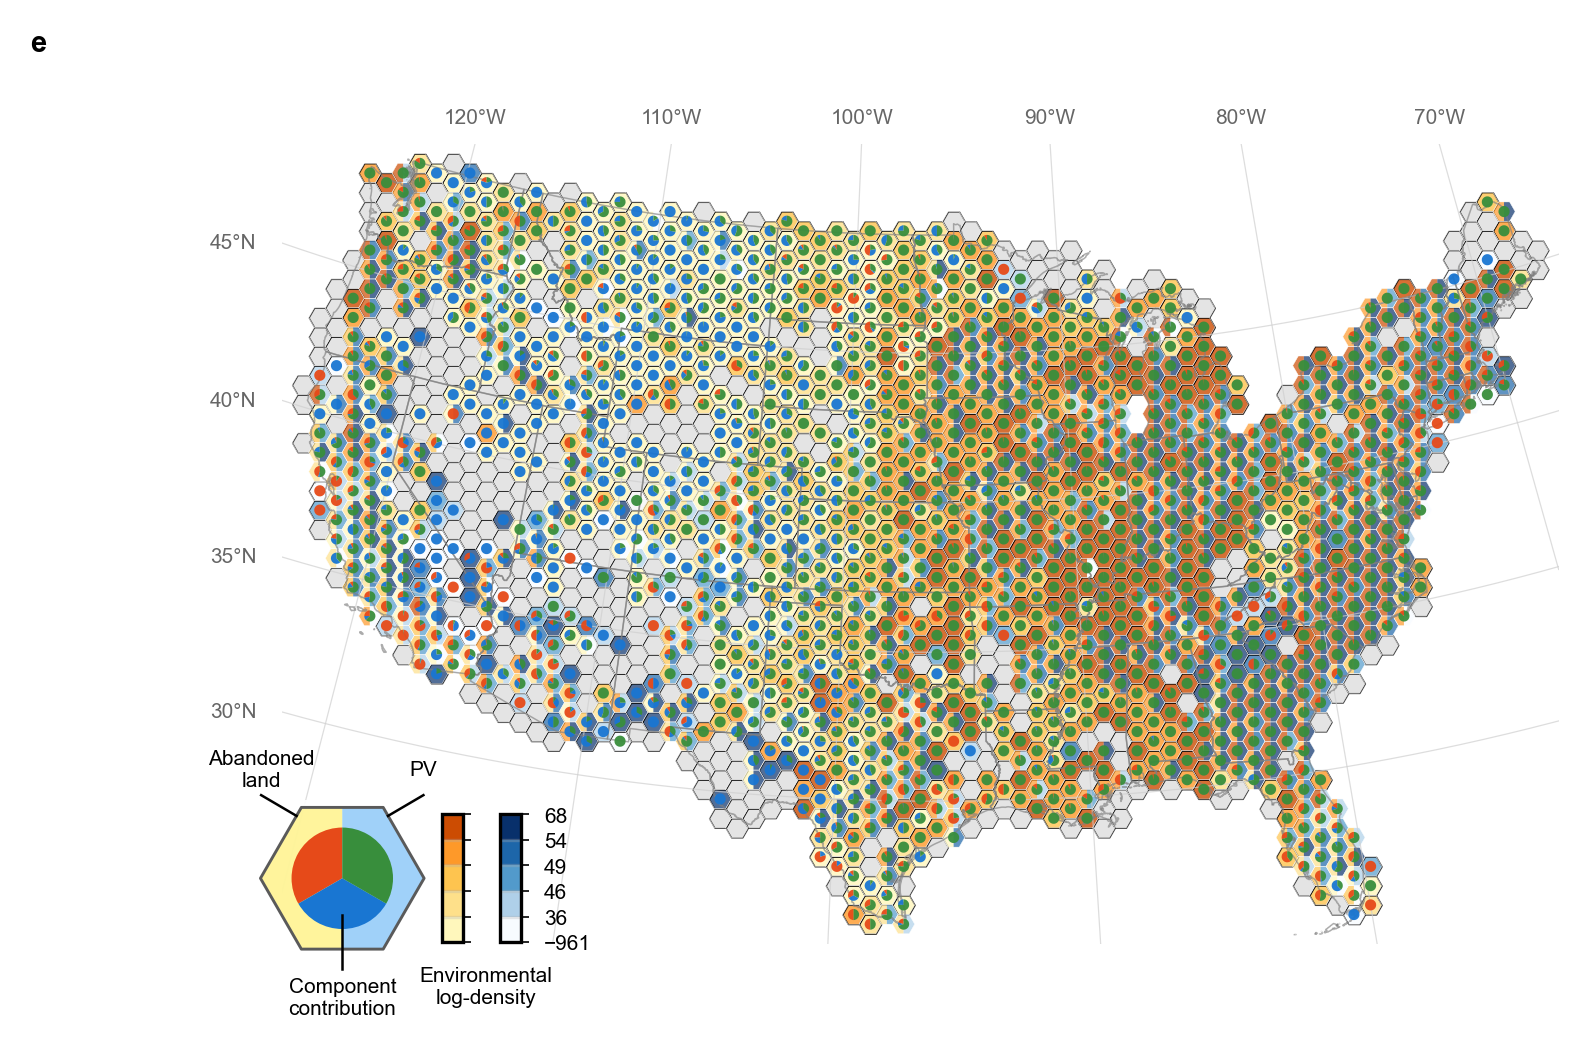

In [25]:
from matplotlib.collections import CircleCollection, PathCollection
from matplotlib.path import Path
from matplotlib import colors, cm
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString, box
from pyproj import Transformer
from matplotlib.patches import Wedge

def build_discrete_quantile_mapper(
    series, 
    custom_cmap=None,
    quantile_breaks=(0.05, 0.20, 0.40, 0.60, 1.00),
    under_color='#F5F5F5',
    over_color=None
):
    """给一列数值构造"离散量化颜色映射"：返回 (mapper, bins, listed_cmap, norm)"""
    vals = np.asarray(series, dtype=float)
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        if custom_cmap is not None:
            listed = custom_cmap
        else:
            cmap = cm.get_cmap('viridis', 5)
            listed = colors.ListedColormap([cmap(i) for i in range(cmap.N)])
        norm = colors.BoundaryNorm([0,1,2,3,4,5], listed.N)
        sm = cm.ScalarMappable(norm=norm, cmap=listed)
        return (lambda v: under_color), [], listed, norm

    qs = np.quantile(vals, quantile_breaks)
    vmin = vals.min()
    bins = np.unique(np.concatenate([[vmin], qs]))
    
    n_colors_needed = len(bins) - 1
    if custom_cmap is not None:
        if custom_cmap.N < n_colors_needed:
            colors_list = [custom_cmap(i / (n_colors_needed - 1)) for i in range(n_colors_needed)]
            listed = colors.ListedColormap(colors_list)
        else:
            listed = colors.ListedColormap([custom_cmap(i) for i in range(n_colors_needed)])
    else:
        base = cm.get_cmap('viridis', n_colors_needed)
        listed = colors.ListedColormap([base(i) for i in range(base.N)])
    
    listed.set_under(under_color)
    if over_color is not None:
        listed.set_over(over_color)
    norm = colors.BoundaryNorm(bins, listed.N, clip=False)
    sm = cm.ScalarMappable(norm=norm, cmap=listed)
    
    def mapper(v):
        if v is None or np.isnan(v):
            return under_color
        return sm.to_rgba(v)
    return mapper, bins, listed, norm

def build_discrete_mapper_from_bins(
    bins, 
    custom_cmap=None,
    under_color='#F5F5F5',
    over_color=None
):
    """基于预定义的 bins 构造颜色映射器（用于统一分级标准）"""
    import matplotlib.colors as mcolors
    import matplotlib.cm as mcm
    
    if len(bins) < 2:
        if custom_cmap is not None:
            listed = custom_cmap
        else:
            cmap = mcm.get_cmap('viridis', 5)
            listed = mcolors.ListedColormap([cmap(i) for i in range(cmap.N)])
        norm = mcolors.BoundaryNorm([0,1,2,3,4,5], listed.N)
        sm = mcm.ScalarMappable(norm=norm, cmap=listed)
        return (lambda v: under_color), bins, listed, norm
    
    bins = np.unique(np.sort(bins))
    n_colors_needed = len(bins) - 1
    
    if custom_cmap is not None:
        if custom_cmap.N < n_colors_needed:
            colors_list = [custom_cmap(i / (n_colors_needed - 1)) for i in range(n_colors_needed)]
            listed = mcolors.ListedColormap(colors_list)
        else:
            listed = mcolors.ListedColormap([custom_cmap(i) for i in range(n_colors_needed)])
    else:
        base = mcm.get_cmap('viridis', n_colors_needed)
        listed = mcolors.ListedColormap([base(i) for i in range(base.N)])
    
    listed.set_under(under_color)
    if over_color is not None:
        listed.set_over(over_color)
    
    norm = mcolors.BoundaryNorm(bins, listed.N, clip=False)
    sm = mcm.ScalarMappable(norm=norm, cmap=listed)
    
    def mapper(v):
        if v is None or np.isnan(v):
            return under_color
        return sm.to_rgba(v)
    
    return mapper, bins, listed, norm

def create_blue_gradient(n=5):
    from matplotlib.colors import LinearSegmentedColormap
    # 色条采用更为科学、单调的研究蓝色调（避免强烈蓝-青跳变，最大限度数据可辨度）
    # 参考ColorBrewer “Blues” 以及cmocean “deep” 渐变，适合科研论文
    blue_cdict = [
        (0.0,  "#f7fbff"),  # very pale blue，Paper friendly background
        (0.2,  "#c6dbef"),  # light blue
        (0.4,  "#6baed6"),  # moderate blue
        (0.7,  "#2171b5"),  # dark blue
        (1.0,  "#08306b"),  # very deep blue
    ]
    cmap = LinearSegmentedColormap.from_list("scientific_blue_gradient", blue_cdict, N=n)
    return cmap

def create_yellow_gradient(n=5):
    from matplotlib.colors import LinearSegmentedColormap
    # 采用ColorBrewer “YlOrBr” 科研常用的黄色-橙棕色调，避免过白起点，提升区分度
    yellow_cdict = [
        (0.0,  "#fff7bc"),  # paper friendly pale yellow，不刺眼
        (0.22, "#fee391"),  # 明显淡黄
        (0.50, "#fec44f"),  # 偏暖亮黄
        (0.75, "#fe9929"),  # 橙黄
        (1.0,  "#cc4c02"),  # warm brown-orange, good end for scale
    ]
    cmap = LinearSegmentedColormap.from_list("scientific_yellow_gradient", yellow_cdict, N=n)
    return cmap
    # 下面的黄色也是用渐变带自然“沙/土”色气氛
    cmap = LinearSegmentedColormap.from_list("smooth_yellow_gradient", cdict, N=n)
    return cmap

def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

def plot_hexagonal_gmm_map(hex_gdf,
                           us_states_gdf,
                           us_nation,
                           pv_pattern=None,
                           ab_pattern=None,
                           cluster_colors=None,
                           pattern_colors=None,
                           pattern_threshold=0.3,
                           circle_scale=0.5,  
                           show_patterns=True,  
                           save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png',
                           figsize=(14, 8),
                           dpi=300,
                           lon_ticks=None,
                           lat_ticks=None):
    """
    使用单色系配色方案：PV用蓝色渐变，Abandon用黄色渐变
    直接基于 ab_pattern 和 pv_pattern 判断数据
    cluster_circle改为饼图，显示每个hex内部数据的cluster分布
    """
    print("\n=== Creating Hexagonal GMM Map (Optimized) ===")

    if cluster_colors is None:
        cluster_colors = {0: '#800020', 1: '#1976d2', 2: '#43a047'}
    if pattern_colors is None:
        pattern_colors = {
            'Socioeconomic': '#e09e21',
            'Infrastructure': '#224183',
            'Geographic': '#229d6e',
            'Climatic': '#a34618',
        }
        
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    unique_clusters = sorted(set(cluster_colors.keys()))

    # 设置120mm宽、100mm高
    mm_to_inch = 1/25.4
    fig_width = 150 * mm_to_inch
    fig_height = 88 * mm_to_inch
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height), dpi=dpi)
    ax.set_facecolor('white')

    # 投影到 Albers
    hex_albers = hex_gdf.to_crs('ESRI:102003')
    states_albers = us_states_gdf.to_crs('ESRI:102003')
    nation_albers = us_nation.to_crs('ESRI:102003')

    xmin, ymin, xmax, ymax = hex_albers.total_bounds
    margin = 38000.0
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)

    # 保留states和nation的边框绘制
    states_albers.plot(ax=ax, color='none', edgecolor='gray',
                       linewidth=0.4, alpha=0.3, zorder=10)
    

    # 移除axes的最外边框（spine）
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    print(f"Plotting {len(hex_albers)} hexagons...")

    # ========== 构建颜色映射器（统一分级标准：使用PV的分级）==========
    blue_cmap = create_blue_gradient(5)
    yellow_cmap = create_yellow_gradient(5)
    
    # 构建PV的离散量化颜色映射器（蓝色渐变）
    pv_color_mapper = None
    pv_listed_cmap = None
    pv_norm = None
    pv_bins = None
    
    if pv_pattern is not None and 'log_density' in pv_pattern.columns:
        pv_logdens = pv_pattern['log_density'].dropna()
        if len(pv_logdens) > 0:
            pv_color_mapper, pv_bins, pv_listed_cmap, pv_norm = build_discrete_quantile_mapper(
                pv_logdens,
                custom_cmap=blue_cmap,
                quantile_breaks=(0.05, 0.20, 0.40, 0.60, 1.00),
                under_color='#F5F5F5'
            )
            print(f"PV logdensity bins: {pv_bins}")
    
    # 构建Abandon的离散量化颜色映射器（黄色渐变）- 使用PV的bins分级标准
    ab_color_mapper = None
    ab_listed_cmap = None
    ab_norm = None
    
    if ab_pattern is not None and 'log_density' in ab_pattern.columns:
        ab_logdens = ab_pattern['log_density'].dropna()
        if len(ab_logdens) > 0:
            if pv_bins is not None and len(pv_bins) > 1:
                # 使用PV的分级标准
                ab_color_mapper, ab_bins, ab_listed_cmap, ab_norm = build_discrete_mapper_from_bins(
                    pv_bins,
                    custom_cmap=yellow_cmap,
                    under_color='#F5F5F5'
                )
                print(f"Abandon logdensity bins (using PV bins): {ab_bins}")
            else:
                # 如果PV没有数据，则使用Abandon自己的分级
                ab_color_mapper, ab_bins, ab_listed_cmap, ab_norm = build_discrete_quantile_mapper(
                    ab_logdens,
                    custom_cmap=yellow_cmap,
                    quantile_breaks=(0.05, 0.20, 0.40, 0.60, 1.00),
                    under_color='#F5F5F5'
                )
                print(f"Abandon logdensity bins (own): {ab_bins}")
    
    # ========== 准备数据：为每个hex计算logdensity均值和cluster分布 ==========
    hex_abandon_logdensity = {}
    hex_pv_logdensity = {}
    hex_cluster_distribution = {}
    
    # 处理ab_pattern
    if ab_pattern is not None and 'log_density' in ab_pattern.columns and 'lat' in ab_pattern.columns and 'lon' in ab_pattern.columns:
        gdf_ab = gpd.GeoDataFrame(
            ab_pattern,
            geometry=gpd.points_from_xy(ab_pattern.lon, ab_pattern.lat),
            crs='EPSG:4326'
        ).to_crs('ESRI:102003')
        
        try:
            joined_ab = gpd.sjoin(gdf_ab, hex_albers, how='inner', predicate='within')
            
            logdensity_col = 'log_density' if 'log_density' in joined_ab.columns else ('log_density_left' if 'log_density_left' in joined_ab.columns else None)
            cluster_col = 'dominant_cluster' if 'dominant_cluster' in joined_ab.columns else ('dominant_cluster_left' if 'dominant_cluster_left' in joined_ab.columns else None)
            
            if logdensity_col:
                for hex_idx, group in joined_ab.groupby('index_right'):
                    if logdensity_col in group.columns:
                        logdens = group[logdensity_col].dropna()
                        if len(logdens) > 0:
                            hex_abandon_logdensity[hex_idx] = logdens.mean()
                    
                    if cluster_col and cluster_col in group.columns:
                        cluster_counts = group[cluster_col].value_counts().to_dict()
                        if hex_idx not in hex_cluster_distribution:
                            hex_cluster_distribution[hex_idx] = {}
                        for cluster_id, count in cluster_counts.items():
                            hex_cluster_distribution[hex_idx][cluster_id] = hex_cluster_distribution[hex_idx].get(cluster_id, 0) + count
        except Exception as e:
            print(f"Warning: Error processing ab_pattern: {e}")
    
    # 处理pv_pattern
    if pv_pattern is not None and 'log_density' in pv_pattern.columns and 'lat' in pv_pattern.columns and 'lon' in pv_pattern.columns:
        gdf_pv = gpd.GeoDataFrame(
            pv_pattern,
            geometry=gpd.points_from_xy(pv_pattern.lon, pv_pattern.lat),
            crs='EPSG:4326'
        ).to_crs('ESRI:102003')
        
        try:
            joined_pv = gpd.sjoin(gdf_pv, hex_albers, how='inner', predicate='within')
            
            logdensity_col = 'log_density' if 'log_density' in joined_pv.columns else ('log_density_left' if 'log_density_left' in joined_pv.columns else None)
            cluster_col = 'dominant_cluster' if 'dominant_cluster' in joined_pv.columns else ('dominant_cluster_left' if 'dominant_cluster_left' in joined_pv.columns else None)
            
            if logdensity_col:
                for hex_idx, group in joined_pv.groupby('index_right'):
                    if logdensity_col in group.columns:
                        logdens = group[logdensity_col].dropna()
                        if len(logdens) > 0:
                            hex_pv_logdensity[hex_idx] = logdens.mean()
                    
                    if cluster_col and cluster_col in group.columns:
                        cluster_counts = group[cluster_col].value_counts().to_dict()
                        if hex_idx not in hex_cluster_distribution:
                            hex_cluster_distribution[hex_idx] = {}
                        for cluster_id, count in cluster_counts.items():
                            hex_cluster_distribution[hex_idx][cluster_id] = hex_cluster_distribution[hex_idx].get(cluster_id, 0) + count
        except Exception as e:
            print(f"Warning: Error processing pv_pattern: {e}")
    
    # 批量计算所有 hex 的中心和半径
    hex_info = []
    for idx, row in hex_albers.iterrows():
        geom = row['geometry']
        if geom.is_empty:
            continue
        centroid = geom.centroid
        cx, cy = centroid.x, centroid.y

        coords = list(geom.exterior.coords)
        if not coords:
            continue
        dists = [np.hypot(x - cx, y - cy) for (x, y) in coords]
        hex_radius_m = float(np.max(dists))
        base_r_m = hex_radius_m * circle_scale

        # 只在需要时计算pattern_shares
        pattern_shares = {}
        if show_patterns:
            pattern_shares = {
                col.replace('pattern_', '').replace('_share', ''): float(row[col])
                for col in hex_gdf.columns
                if col.startswith('pattern_') and col.endswith('_share') and np.isfinite(row[col])
            }
        
        hex_info.append({
            'idx': idx,
            'center': (cx, cy),
            'geometry': geom,  
            'base_r_meters': base_r_m,
            'pattern_shares': pattern_shares,
        })

    # ========== 分类 hex ==========
    hex_with_abandon = set(hex_abandon_logdensity.keys())
    hex_with_pv = set(hex_pv_logdensity.keys())
    
    hex_only_abandon = hex_with_abandon - hex_with_pv
    hex_only_pv = hex_with_pv - hex_with_abandon
    hex_both = hex_with_abandon & hex_with_pv
    hex_neither = set(hex_albers.index) - (hex_with_abandon | hex_with_pv)

    # 绘制只有 abandon 数据的 hex
    for idx in hex_only_abandon:
        hex_data = next((info for info in hex_info if info['idx'] == idx), None)
        if hex_data is None:
            continue
        
        hex_geom = hex_data['geometry']
        if hex_geom.is_empty:
            continue
        
        if idx in hex_abandon_logdensity and ab_color_mapper is not None:
            logdens_mean = hex_abandon_logdensity[idx]
            fill_color = ab_color_mapper(logdens_mean)
            if isinstance(fill_color, (tuple, np.ndarray)) and len(fill_color) >= 3:
                fill_color = tuple(fill_color[:3])
            else:
                fill_color = '#F5F5F5'
        else:
            fill_color = '#F5F5F5'
        
        gpd.GeoSeries([hex_geom], crs=hex_albers.crs).plot(
            ax=ax, color=fill_color, edgecolor='black', linewidth=0.3, alpha=0.8, zorder=0.5
        )
    
    # 绘制只有 PV 数据的 hex
    for idx in hex_only_pv:
        hex_data = next((info for info in hex_info if info['idx'] == idx), None)
        if hex_data is None:
            continue
        
        hex_geom = hex_data['geometry']
        if hex_geom.is_empty:
            continue
        
        if idx in hex_pv_logdensity and pv_color_mapper is not None:
            logdens_mean = hex_pv_logdensity[idx]
            fill_color = pv_color_mapper(logdens_mean)
            if isinstance(fill_color, (tuple, np.ndarray)) and len(fill_color) >= 3:
                fill_color = tuple(fill_color[:3])
            else:
                fill_color = '#F5F5F5'
        else:
            fill_color = '#F5F5F5'
        
        gpd.GeoSeries([hex_geom], crs=hex_albers.crs).plot(
            ax=ax, color=fill_color, edgecolor='black', linewidth=0.3, alpha=0.7, zorder=0.5
        )
    
    # 绘制没有数据的 hex
    # 临时设置hatch线条更细
    original_hatch_linewidth = plt.rcParams.get('hatch.linewidth', 1.0)
    plt.rcParams['hatch.linewidth'] = 0.3
    
    for idx in hex_neither:
        hex_data = next((info for info in hex_info if info['idx'] == idx), None)
        if hex_data is None:
            continue
        
        hex_geom = hex_data['geometry']
        if hex_geom.is_empty:
            continue
        
        gpd.GeoSeries([hex_geom], crs=hex_albers.crs).plot(
            ax=ax, color='#D9D9D9', edgecolor='black', linewidth=0.3, alpha=0.7, 
            zorder=0.5
        )
    
    # 恢复原始hatch线条宽度
    plt.rcParams['hatch.linewidth'] = original_hatch_linewidth
    
    # 绘制同时有 abandon 和 PV 数据的 hex（左右分割）
    for idx in hex_both:
        hex_data = next((info for info in hex_info if info['idx'] == idx), None)
        if hex_data is None:
            continue
        
        hex_geom = hex_data['geometry']
        if hex_geom.is_empty:
            continue
        
        centroid = hex_geom.centroid
        cx_split, cy_split = centroid.x, centroid.y
        
        miny, maxy = hex_geom.bounds[1], hex_geom.bounds[3]
        y_range = maxy - miny
        padding = y_range * 0.2
        
        half_line = LineString([(cx_split, miny - padding), (cx_split, maxy + padding)])
        
        visible_line = half_line.intersection(hex_geom.boundary)
        if not visible_line.is_empty:
            if visible_line.geom_type == 'LineString':
                xs, ys = visible_line.xy
                ax.plot(xs, ys, color='gray', linewidth=1.0, zorder=1)
            elif visible_line.geom_type == 'MultiLineString':
                for line in visible_line.geoms:
                    xs, ys = line.xy
                    ax.plot(xs, ys, color='gray', linewidth=1.0, zorder=1)
        
        try:
            left_poly = hex_geom.intersection(Polygon([
                (hex_geom.bounds[0] - 1000, miny - 1000),
                (cx_split, miny - 1000),
                (cx_split, maxy + 1000),
                (hex_geom.bounds[0] - 1000, maxy + 1000)
            ]))
            
            right_poly = hex_geom.intersection(Polygon([
                (cx_split, miny - 1000),
                (hex_geom.bounds[2] + 1000, miny - 1000),
                (hex_geom.bounds[2] + 1000, maxy + 1000),
                (cx_split, maxy + 1000)
            ]))
            
            if not left_poly.is_empty and left_poly.area > 0:
                if idx in hex_abandon_logdensity and ab_color_mapper is not None:
                    logdens_mean = hex_abandon_logdensity[idx]
                    left_color = ab_color_mapper(logdens_mean)
                    if isinstance(left_color, (tuple, np.ndarray)) and len(left_color) >= 3:
                        left_color = tuple(left_color[:3])
                    else:
                        left_color = '#F5F5F5'
                else:
                    left_color = '#F5F5F5'
                
                gpd.GeoSeries([left_poly], crs=hex_albers.crs).plot(
                    ax=ax, color=left_color, edgecolor='none', alpha=0.7, zorder=0.5
                )
            
            if not right_poly.is_empty and right_poly.area > 0:
                if idx in hex_pv_logdensity and pv_color_mapper is not None:
                    logdens_mean = hex_pv_logdensity[idx]
                    right_color = pv_color_mapper(logdens_mean)
                    if isinstance(right_color, (tuple, np.ndarray)) and len(right_color) >= 3:
                        right_color = tuple(right_color[:3])
                    else:
                        right_color = '#F5F5F5'
                else:
                    right_color = '#F5F5F5'
                
                gpd.GeoSeries([right_poly], crs=hex_albers.crs).plot(
                    ax=ax, color=right_color, edgecolor='none', alpha=0.7, zorder=0.5
                )
        except Exception:
            hex_albers.loc[[idx]].plot(
                ax=ax, color='#d4e3d4', edgecolor='black', linewidth=0.3,
                alpha=0.8, zorder=0.5
            )
    
    # 绘制六边形边线（所有 hex）
    hex_albers.plot(ax=ax, color='none', edgecolor='white', linewidth=0.1, zorder=0.6)
    # 在hex绘制完成后，绘制州界（确保在hex之上）
    states_albers.plot(ax=ax, color='none', edgecolor='gray',
                       linewidth=0.3, alpha=0.5, zorder=8)

    # ========== 绘制cluster饼图 ==========
    for info in hex_info:
        idx = info['idx']
        x, y = info['center']
        base_r_m = info['base_r_meters']
        
        if idx in hex_cluster_distribution:
            cluster_dist = hex_cluster_distribution[idx]
            total_count = sum(cluster_dist.values())
            
            if total_count > 0:
                start_angle = 90
                for cluster_id in sorted(cluster_dist.keys()):
                    if cluster_id in cluster_colors:
                        count = cluster_dist[cluster_id]
                        angle = (count / total_count) * 360
                        wedge = Wedge(
                            (x, y), base_r_m,
                            start_angle, start_angle + angle,
                            facecolor=cluster_colors[cluster_id],
                            edgecolor='none',
                            linewidth=0,
                            alpha=0.95,
                            zorder=10
                        )
                        ax.add_patch(wedge)
                        start_angle += angle

    # ========== 绘制经纬网格 ==========
    if lon_ticks is None:
        lon_ticks = np.arange(-130, -65, 10)
    if lat_ticks is None:
        lat_ticks = np.arange(30, 50, 5)
    
    usa_bounds_main = {
        'lon_min': -130,
        'lon_max': -65,
        'lat_min': 25,
        'lat_max': 50
    }
    
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ========== 添加图例 ==========
    legend_ax = add_legend_panel(
        fig,
        cluster_colors, pattern_colors, unique_clusters,
        legend_pos='sw',
        size_inch=(0.6, 0.6),
        margin_inch=(0.8, 0.3),
        pv_listed_cmap=pv_listed_cmap, pv_norm=pv_norm,
        ab_listed_cmap=ab_listed_cmap, ab_norm=ab_norm,
        show_pattern=False
    )
    fig.text(
        0.01, 0.99, 'e',
        fontsize=7,
        fontweight='bold',
        va='top',
        ha='left'
        )

        

    print(f"Saving to: {save_path}")
    fig.savefig(save_path, dpi=dpi, facecolor='white')
    pdf_path = save_path.replace('.png', '.pdf')
    fig.savefig(pdf_path, dpi=dpi, facecolor='white')
    print(f"Saving to: {pdf_path}")
    
    return fig, ax

# 使用示例
fig, ax = plot_hexagonal_gmm_map(
    hex_gdf_h4,
    us_states,
    us_nation,
    pv_pattern = pv_pattern,
    ab_pattern = ab_pattern,
    cluster_colors = {
        1: '#E64A19',  # 橙红色 (替代纯红，更易区分)
        2: '#1976D2',  # 深蓝色 (保持)
        3: '#388E3C',  # 深绿色 (替代亮绿，更易区分)
    },
    pattern_colors={
        'Socioeconomic': '#e09e21',
        'Infrastructure': '#224183',
        'Geographic': '#229d6e',
        'Climatic': '#a34618',
    },
    pattern_threshold=0.3,
    circle_scale=0.5,  
    show_patterns=False,  
    save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png',
)

# 3、环境结构图

In [16]:
import geopandas as gpd
from shapely.geometry import Point
from function import *
%matplotlib inline


us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]
df_abandon = df_abandon[
    (df_abandon['lon'] >= usa_bounds_main['lon_min']) &
    (df_abandon['lon'] <= usa_bounds_main['lon_max']) &
    (df_abandon['lat'] >= usa_bounds_main['lat_min']) &
    (df_abandon['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_nation)
df_embedding = clip_data_with_us_states(df_embedding, us_nation)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]



You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


## 3.1 PV环境结构组合

In [19]:
manual_cluster_patterns = {
    1: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    },
    2: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Geographic',
                'arrow_color': '#000080',
                'arrow_direction': 'up'
            }
        ]
    },
    3: {
        'blocks': [
            {
                
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            { 
                'pattern': 'Geographic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'

            }
        ]
    },
    4: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Climatic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    }
}




=== Landcover统计（定量映射后） ===
Dominant landcover类别: [6 8 2 3 1 2 4 6 3 4]...
Landcover编码后范围: [-3.000, 3.000]
✅ Landcover已通过规则编码: Socio/Infra=+3, Climatic=0, Geographic=-3，再乘dominant概率

=== 层次聚类信息 ===
聚类使用的特征数量: 23 (numeric: 14 + landcover: 9)
实际聚类数量: 3

=== 使用输入数据计算Cluster百分比 ===
输入数据形状: (10473, 27)
使用预测概率计算的cluster百分比:
  Cluster 1: 38.97%
  Cluster 2: 8.24%
  Cluster 3: 52.79%

=== 聚类分析结果 ===
聚类数量: 3
边界位置: [7, 14]
Cluster 1: ['C4', 'C7', 'C10', 'C15', 'C17', 'C1', 'C13']
Cluster 2: ['C6', 'C12', 'C14', 'C5', 'C18', 'C0', 'C22']
Cluster 3: ['C11', 'C19', 'C16', 'C21', 'C8', 'C2', 'C20', 'C3', 'C9']

=== 数据分布统计（二次标准化后） ===
数据范围: [-2.212, 4.475]
归一化范围: [-3.000, 0.0, 3.000] (TwoSlopeNorm, vcenter=0, 固定±3.0)

=== 动态阈值计算（基于数据分布） ===
均值: 0.000, 标准差: 1.000, 中位数: -0.283
25%分位数: -0.650, 75%分位数: 0.583
高值阈值 (> 0.583): 显示向上箭头（深色区）
低值阈值 (< -0.650): 显示向下箭头（极浅区）

检测到的Cluster IDs: [1, 2, 3]
Cell size: 10.6 x 11.5 px
Marker size: 16.0 points^2
✅ Component 20 已在热力图中高亮（位置索引: 20, x范围: [200, 210]）


C:\Users\zpy10\AppData\Local\Temp\ipykernel_37008\3388984212.py:591: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_heatmap.scatter(xx_flat_heat[mid_heat], yy_flat_heat[mid_heat],


✅ Saved: figure/US_figure/component_patterns_final.png


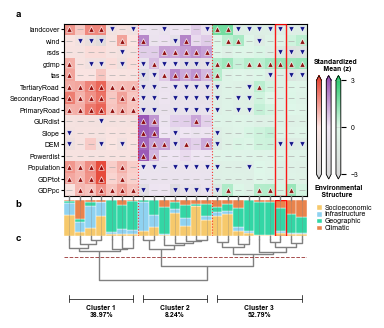

In [62]:

import joblib
from numba.cuda.simulator.api import jit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle, Patch
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D




def create_cluster_patch_label(ax_cluster, center_x, y_pos, cluster_id, manual_patterns, pattern_colors, cluster_percentages=None):
    """
    创建cluster标签和patch
    
    Parameters
    ----------
    ax_cluster : matplotlib.axes.Axes
        聚类标记轴
    center_x : float
        cluster中心x坐标
    y_pos : float
        y位置
    cluster_id : int
        cluster ID
    manual_patterns : dict
        手动定义的cluster模式信息
    pattern_colors : dict
        模式颜色字典
    cluster_percentages : dict, optional
        cluster_id到百分比的映射，格式为 {cluster_id: percentage_value}
        如果为None，则不显示百分比
    """
    if cluster_id not in manual_patterns:
        return

    cluster_info = manual_patterns[cluster_id]
    num_blocks = len(cluster_info['blocks'])
    if num_blocks < 1:
        return

    # 单个矩形的宽度和高度
    single_width = 15         
    single_height = 0.8        
    gap = 6  

    # 整个组合Patch的宽度和开始坐标
    total_width = num_blocks * single_width + (num_blocks-1)*gap
    patch_start_x = center_x - total_width/2
    patch_start_y = y_pos - single_height/2


    # 动态获取百分比（如果提供）
    percent_str = ""
    if cluster_percentages is not None and cluster_id in cluster_percentages:
        percentage = cluster_percentages[cluster_id]
        percent_str = f"\n{percentage:.2f}%"
    
    # 显示Cluster ID和百分比
    ax_cluster.text(
        center_x, patch_start_y - 0.3,
        f'Cluster {cluster_id}{percent_str}', 
        ha='center', va='top', fontsize=5, fontweight='bold'
    )


def draw_connectors(fig, ax_ref, ax_top, ax_bottom, centers, color='0.75', lw=0.6, alpha=0.35):
    """
    在 figure 坐标系画竖线，连接 ax_top 的底边 ↔ ax_bottom 的顶边。
    ax_ref: 用来把数据x转换到屏幕坐标的参考轴（和 centers 的坐标系一致，通常是 ax_heatmap）
    centers: 各 component 的数据坐标 x 中心（如 [(i+0.5)*10 for i in range(n)]）
    """
    inv = fig.transFigure.inverted()
    # 两个轴在 figure 中的矩形位置
    y0 = ax_bottom.get_position().y1   # heatmap 顶边
    y1 = ax_top.get_position().y0      # pattern 底边
    for x in centers:
        # 数据坐标 -> 显示坐标 -> Figure 坐标
        x_disp = ax_ref.transData.transform((x, 0))[0]
        x_fig = inv.transform((x_disp, 0))[0]
        line = Line2D([x_fig, x_fig], [y0, y1],
                      transform=fig.transFigure, color="gray", lw=lw, alpha=alpha,
                      zorder=5)  # zorder 可调：大一点在前，小一点在后
        fig.add_artist(line)


def plot_gmm_component_patterns(
    model_path: str = "gmm_model_23c_fixed.pkl",
    save_path: str = None,
    df_data: pd.DataFrame = None,  # 新增：用于计算cluster百分比的数据
):
    """GMM Component-Feature Pattern可视化（优化版 - 等高度模式条+横向图例+聚类边界）"""
    
    # ========== 加载模型 ==========
    gmm_pipeline = joblib.load(model_path)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    n_components = gmm.n_components
    
    # ========== 特征处理 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    # --- landcover编码/处理 ---
    # 用自定义规则将landcover分类做定量中心化，见下
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        
        # 获取每个component的dominant landcover类别（0-based索引）
        dominant_landcover_indices = np.argmax(landcover_means, axis=1)  # shape: (n_components,)
        dominant_landcover_classes = dominant_landcover_indices + 1  # 1-based
        
        # landcover到pattern规则
        landcover_to_pattern = {
            1: ['Socioeconomic'], 
            2: ['Geographic'], 
            3: ['Geographic'],
            4: ['Geographic'], 
            5: ['Geographic'], 
            6: ['Climatic'],
            7: ['Socioeconomic', 'Infrastructure'], 
            8: ['Geographic'], 
            9: ['Climatic'],
        }
        # landcover自定义编码规则：大负值为Geographic, 中间为Climatic, 大正为Socio和Infra
        # 便于二次标准化后呈现明显区分
        LC_CENTERMAP = {
            1: 3.0,   # Socioeconomic
            2: -3.0,  # Geographic
            3: -3.0,  # Geographic
            4: -3.0,  # Geographic
            5: -3.0,  # Geographic
            6: 0.0,   # Climatic
            7: 3.0,   # Socioeconomic/Infrastructure
            8: -3.0,  # Geographic
            9: 0.0,   # Climatic
        }
        # 本质上LC_CENTERMAP: Socio/Infra=+3, Geographic=-3, Climatic=0

        # dominant值*编码后作为用于热力图display的landcover“数值”
        encoded_dom_lc_val = np.array([
            LC_CENTERMAP[lc] for lc in dominant_landcover_classes
        ]) * np.take_along_axis(
            landcover_means, dominant_landcover_indices[:, np.newaxis], axis=1
        ).squeeze()
        
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            encoded_dom_lc_val[:, np.newaxis]
        ])
        n_landcover_cats = landcover_means.shape[1]
    else:
        component_features_std = means
        landcover_means = None
        dominant_landcover_classes = None

    all_features = numeric_features + categorical_features

    # ========== 方差提取 ==========
    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)

    if categorical_features:
        landcover_variances = variances[:, n_numeric:]
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True)
        ])
    else:
        variances_for_display = variances

    # ========== 定义模式和颜色（使用Okabe-Ito配色） ==========
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }

    pattern_colors = {
        'Socioeconomic': '#f6c96c',  # 浅橙色
        'Infrastructure': '#8fd2f1',  # 浅蓝色
        'Geographic': '#33d6a5',     # 浅绿色
        'Climatic': '#e9834c',       # 浅红棕色
    }

    # ========== Landcover相关输出 ==========
    if categorical_features and dominant_landcover_classes is not None:
        print(f"\n=== Landcover统计（定量映射后） ===")
        print(f"Dominant landcover类别: {dominant_landcover_classes[:10]}...")
        print(f"Landcover编码后范围: [{np.min(encoded_dom_lc_val):.3f}, {np.max(encoded_dom_lc_val):.3f}]")
        print(f"✅ Landcover已通过规则编码: Socio/Infra=+3, Climatic=0, Geographic=-3，再乘dominant概率")

    # ========== 计算模式得分并归一化（改进方法：基于方差解释比例和信息量） ==========
    def calculate_pattern_weights(comp_idx):
        """
        计算并返回归一化的模式权重
        改进方法：
        1. 使用特征对component方差解释的比例（类似PCA的思想）
        2. 结合标准化均值的平方（信息量）和方差（区分度）
        3. 考虑component权重作为全局重要性
        """
        scores = {name: 0.0 for name in feature_groups.keys()}

        if gmm.covariance_type == 'full':
            comp_cov = covariances[comp_idx]
            if n_numeric > 0:
                comp_cov_numeric = comp_cov[:n_numeric, :n_numeric]
            else:
                comp_cov_numeric = np.zeros((0, 0))
        else:
            comp_cov_numeric = np.diag(variances_for_display[comp_idx, :n_numeric]) if n_numeric > 0 else np.zeros((0, 0))

        if gmm.covariance_type == 'full' and n_numeric > 0:
            eigenvals = np.linalg.eigvals(comp_cov_numeric)
            comp_total_variance = np.sum(eigenvals[eigenvals > 0])
        else:
            comp_total_variance = np.sum(variances_for_display[comp_idx, :])

        for pattern_name, features in feature_groups.items():
            indices = [all_features.index(f) for f in features if f in all_features]
            if indices:
                pattern_means = component_features_std[comp_idx, indices]

                if gmm.covariance_type == 'full' and n_numeric > 0:
                    pattern_indices_numeric = [idx for idx in indices if idx < n_numeric]
                    if len(pattern_indices_numeric) > 0:
                        pattern_cov = comp_cov_numeric[np.ix_(pattern_indices_numeric, pattern_indices_numeric)]
                        pattern_eigenvals = np.linalg.eigvals(pattern_cov)
                        pattern_total_variance = np.sum(np.abs(pattern_eigenvals))
                    else:
                        pattern_total_variance = 0.0
                    pattern_indices_non_numeric = [idx for idx in indices if idx >= n_numeric]
                    if len(pattern_indices_non_numeric) > 0:
                        pattern_variances_non_numeric = variances_for_display[comp_idx, pattern_indices_non_numeric]
                        pattern_total_variance += np.sum(pattern_variances_non_numeric)
                else:
                    pattern_variances = variances_for_display[comp_idx, indices]
                    pattern_total_variance = np.sum(pattern_variances)

                pattern_variance_contrib = pattern_total_variance / (comp_total_variance + 1e-10)
                mean_squared = pattern_means ** 2
                pattern_info = np.mean(mean_squared) if len(mean_squared) > 0 else 0.0
                pattern_score = pattern_variance_contrib * pattern_info * weights[comp_idx]
                scores[pattern_name] = pattern_score

        # Landcover贡献
        if landcover_means is not None:
            lc_total_variance = np.sum(landcover_variances[comp_idx, :]) if landcover_variances.shape[1] > 0 else 1.0
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_variance = landcover_variances[comp_idx, lc_idx]
                    lc_variance_contrib = lc_variance / (lc_total_variance + 1e-10)
                    lc_mean_squared = landcover_means[comp_idx, lc_idx] ** 2
                    lc_contrib = lc_variance_contrib * lc_mean_squared * weights[comp_idx]
                    for pattern in patterns:
                        if pattern in scores:
                            scores[pattern] += lc_contrib / len(patterns)

        total = sum(scores.values())
        if total > 1e-10:
            weights_dict = {k: v/total for k, v in scores.items()}
        else:
            weights_dict = {k: 1.0/len(feature_groups) for k in feature_groups.keys()}

        return weights_dict
    
    # 计算所有components的模式权重
    pattern_weights_list = []
    for k in range(n_components):
        pattern_weights_list.append(calculate_pattern_weights(k))
    
    # ========== 层次聚类 ==========
    # 只使用numeric特征进行聚类，排除自定义编码后的landcover
    # component_features_for_clustering = means[:, :n_numeric]
    # distance_matrix = pdist(component_features_for_clustering, metric='correlation')
    # linkage_matrix = linkage(distance_matrix, method='ward')
    # cluster_labels = fcluster(linkage_matrix, t=1.5, criterion='distance')
    # print(f"\n=== 层次聚类信息 ===")
    # print(f"聚类使用的特征数量: {n_numeric} (仅numeric特征，排除landcover)")
    # print(f"实际聚类数量: {len(set(cluster_labels))}")
    if categorical_features:
        # 包含完整的landcover概率分布（保留所有类别的信息）
        component_features_for_clustering = np.column_stack([
            means[:, :n_numeric],      # numeric特征
            means[:, n_numeric:]        # 完整的landcover概率分布（所有类别）
        ])
        n_features_for_clustering = n_numeric + means[:, n_numeric:].shape[1]
        print(f"\n=== 层次聚类信息 ===")
        print(f"聚类使用的特征数量: {n_features_for_clustering} (numeric: {n_numeric} + landcover: {means[:, n_numeric:].shape[1]})")
    else:
        # 如果没有categorical特征，只使用numeric特征
        component_features_for_clustering = means[:, :n_numeric]
        n_features_for_clustering = n_numeric
        print(f"\n=== 层次聚类信息 ===")
        print(f"聚类使用的特征数量: {n_numeric} (仅numeric特征，无landcover)")

    distance_matrix = pdist(component_features_for_clustering, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=1.5, criterion='distance')
    print(f"实际聚类数量: {len(set(cluster_labels))}")
    # ========== 计算cluster百分比 ==========
    if df_data is not None:
        print("\n=== 使用输入数据计算Cluster百分比 ===")
        print(f"输入数据形状: {df_data.shape}")

        clusters_dict = {}
        for comp_idx in range(n_components):
            cluster_id = cluster_labels[comp_idx]
            if cluster_id not in clusters_dict:
                clusters_dict[cluster_id] = []
            clusters_dict[cluster_id].append(comp_idx)

        features_in_order = numeric_features + categorical_features
        missing_features = [f for f in features_in_order if f not in df_data.columns]
        if missing_features:
            print(f"⚠️ 警告：以下特征在df_data中不存在: {missing_features}")
            print("将使用训练权重（gmm.weights_）计算百分比")
            use_weights = True
        else:
            X_transformed = preprocessor.transform(df_data[features_in_order])
            component_probs = gmm.predict_proba(X_transformed)
            
            sorted_cluster_ids = sorted(clusters_dict.keys())
            n_clusters = len(sorted_cluster_ids)
            n_samples = len(df_data)
            cluster_probs = np.zeros((n_samples, n_clusters))
            for cluster_idx, cluster_id in enumerate(sorted_cluster_ids):
                component_indices = clusters_dict[cluster_id]
                cluster_probs[:, cluster_idx] = component_probs[:, component_indices].sum(axis=1)
            cluster_prob_means = cluster_probs.mean(axis=0)
            cluster_percentages = {}
            for cluster_idx, cluster_id in enumerate(sorted_cluster_ids):
                cluster_percentages[cluster_id] = cluster_prob_means[cluster_idx] * 100
            print(f"使用预测概率计算的cluster百分比:")
            for cluster_id in sorted_cluster_ids:
                print(f"  Cluster {cluster_id}: {cluster_percentages[cluster_id]:.2f}%")
            use_weights = False
    else:
        print("\n=== 使用训练权重（gmm.weights_）计算Cluster百分比 ===")
        use_weights = True

    if use_weights:
        clusters_dict = {}
        for comp_idx in range(n_components):
            cluster_id = cluster_labels[comp_idx]
            if cluster_id not in clusters_dict:
                clusters_dict[cluster_id] = []
            clusters_dict[cluster_id].append(comp_idx)
        cluster_percentages = {}
        for cluster_id, component_indices in clusters_dict.items():
            cluster_weight = sum(weights[comp_idx] for comp_idx in component_indices)
            cluster_percentages[cluster_id] = cluster_weight * 100
        print("基于component weights计算的cluster百分比:")
        for cluster_id in sorted(cluster_percentages.keys()):
            print(f"  Cluster {cluster_id}: {cluster_percentages[cluster_id]:.2f}%")
    
    def find_cluster_boundaries(dendro_order, cluster_labels):
        boundaries = []
        current_cluster = cluster_labels[dendro_order[0]]
        for i in range(1, len(dendro_order)):
            if cluster_labels[dendro_order[i]] != current_cluster:
                boundaries.append(i)
                current_cluster = cluster_labels[dendro_order[i]]
        return boundaries

    # ========== 可视化 ==========
    mm_to_inch = 1/25.4
    fig = plt.figure(figsize=(92*mm_to_inch, 80*mm_to_inch)) 
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    gs = gridspec.GridSpec(4, 1, height_ratios=[1.2, 0.25, 0.3, 0.15], hspace=0.05, 
                    left=0.15, right=0.82, top=0.95, bottom=0.05)

    ax_heatmap = fig.add_subplot(gs[0])
    
    plt.rcParams['lines.linewidth'] = 1
    from scipy.cluster.hierarchy import dendrogram
    dendro_temp = dendrogram(
        linkage_matrix, 
        no_plot=True,
        no_labels=True
    )
    dendro_order = dendro_temp['leaves']
    boundaries = find_cluster_boundaries(dendro_order, cluster_labels)
    
    print("\n=== 聚类分析结果 ===")
    print(f"聚类数量: {len(set(cluster_labels))}")
    print(f"边界位置: {boundaries}")
    clusters = {}
    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(f'C{comp_idx}')
    for cluster_id, components in clusters.items():
        print(f"Cluster {cluster_id}: {components}")

    # --- 二次标准化用于热力图显示 ---
    H = component_features_std.copy()
    if n_numeric > 0:
        mu = H[:, :n_numeric].mean(axis=0, keepdims=True)
        sd = H[:, :n_numeric].std(axis=0, keepdims=True) + 1e-9
        H[:, :n_numeric] = (H[:, :n_numeric] - mu) / sd
    if categorical_features:
        lc = H[:, n_numeric:n_numeric+1]
        lc_mu = lc.mean(axis=0, keepdims=True)
        lc_sd = lc.std(axis=0, keepdims=True) + 1e-9
        H[:, n_numeric:n_numeric+1] = (lc - lc_mu) / lc_sd
    heatmap_data = H[dendro_order, :].T

    x_min, x_max = 0, n_components * 10
    extent = [x_min, x_max, len(all_features), 0]

    # 固定归一化范围为±3.0（与colorbar刻度一致）
    v = 3.0
    norm_vmin = -v
    norm_vmax = v
    
    print(f"\n=== 数据分布统计（二次标准化后） ===")
    print(f"数据范围: [{np.min(heatmap_data):.3f}, {np.max(heatmap_data):.3f}]")
    print(f"归一化范围: [{norm_vmin:.3f}, 0.0, {norm_vmax:.3f}] (TwoSlopeNorm, vcenter=0, 固定±3.0)")

    data_mean = np.mean(heatmap_data)
    data_std = np.std(heatmap_data)
    data_median = np.median(heatmap_data)
    q25 = np.percentile(heatmap_data, 25)
    q75 = np.percentile(heatmap_data, 75)
    thr_high = q75
    thr_low = q25
    print(f"\n=== 动态阈值计算（基于数据分布） ===")
    print(f"均值: {data_mean:.3f}, 标准差: {data_std:.3f}, 中位数: {data_median:.3f}")
    print(f"25%分位数: {q25:.3f}, 75%分位数: {q75:.3f}")
    print(f"高值阈值 (> {thr_high:.3f}): 显示向上箭头（深色区）")
    print(f"低值阈值 (< {thr_low:.3f}): 显示向下箭头（极浅区）")

    base_cluster_colors = {
        1: '#E74C3C',
        2: '#9B59B6',  
        3: '#2ECC71',
    }
    extra_cluster_colors = {
        4: '#F39C12',
        5: '#9B59B6',
        6: '#E67E22',
        7: '#16A085',
        8: '#C0392B',
    }
    unique_cluster_ids = sorted(set(cluster_labels))
    print(f"\n检测到的Cluster IDs: {unique_cluster_ids}")
    cluster_colors = {}
    for cluster_id in unique_cluster_ids:
        if cluster_id in base_cluster_colors:
            cluster_colors[cluster_id] = base_cluster_colors[cluster_id]
        elif cluster_id in extra_cluster_colors:
            cluster_colors[cluster_id] = extra_cluster_colors[cluster_id]
            print(f"⚠️ 警告：cluster {cluster_id} 使用额外颜色: {extra_cluster_colors[cluster_id]}")
        else:
            color_list = list(extra_cluster_colors.values())
            color_idx = (cluster_id - 4) % len(color_list)
            cluster_colors[cluster_id] = color_list[color_idx]
            print(f"⚠️ 警告：cluster {cluster_id} 使用循环颜色: {cluster_colors[cluster_id]}")

    from matplotlib.colors import LinearSegmentedColormap
    def _hex_to_rgb01(hex_color: str):
        return np.array([int(hex_color[i:i+2], 16) for i in (1,3,5)], dtype=float) / 255.0
    def _blend_with_white(rgb, tint):
        white = np.array([1.0, 1.0, 1.0])
        return white * tint + rgb * (1.0 - tint)
    def create_monohue_no_gray_cmap(base_hex: str,
                                    low_tint=0.92,
                                    mid_tint=0.85,
                                    high_gain=1.00,
                                    n=256):
        base = _hex_to_rgb01(base_hex)
        # vmin处：接近灰色（浅灰色），而不是极浅的同色
        gray = np.array([0.85, 0.85, 0.85])  # 浅灰色
        c_low = gray  # 最小值使用灰色
        c_mid  = _blend_with_white(base, mid_tint)
        c_high = np.clip(base * high_gain, 0, 1)
        return LinearSegmentedColormap.from_list(
            f"mono_{base_hex}",
            [(0.0, tuple(c_low)),
             (0.5, tuple(c_mid)),
             (1.0, tuple(c_high))],
            N=n
        )

    cluster_cmaps = {}
    for cluster_id, color in cluster_colors.items():
        cluster_cmaps[cluster_id] = create_monohue_no_gray_cmap(color, n=256)

    norm = colors.TwoSlopeNorm(vcenter=0.0, vmin=norm_vmin, vmax=norm_vmax)

    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        col_data = heatmap_data[:, i:i+1]
        x_start = i * 10
        x_end = (i + 1) * 10
        col_extent = [x_start, x_end, len(all_features), 0]
        cmap = cluster_cmaps[cluster_id]
        ax_heatmap.imshow(
            col_data, 
            cmap=cmap, 
            norm=norm, 
            aspect='auto', 
            interpolation='nearest', 
            extent=col_extent, 
            origin='upper'
        )


    temp_data = np.linspace(norm_vmin, norm_vmax, 100).reshape(-1, 1)
    temp_extent = [0, 1, 100, 0]
    temp_ims = {}
    sorted_cluster_ids = sorted(cluster_colors.keys())
    for cluster_id in sorted_cluster_ids:
        temp_im = ax_heatmap.imshow(
            temp_data,
            cmap=cluster_cmaps[cluster_id],
            norm=norm,
            aspect='auto',
            interpolation='nearest',
            extent=temp_extent,
            origin='upper',
            visible=False
        )
        temp_ims[cluster_id] = temp_im
    im = temp_ims[sorted_cluster_ids[0]]

    x_centers_heat = np.array([(i + 0.5) * 10 for i in range(n_components)])
    y_centers_heat = np.arange(len(all_features)) + 0.5
    XX_heat, YY_heat = np.meshgrid(x_centers_heat, y_centers_heat)
    vals_heat = heatmap_data

    bbox = ax_heatmap.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_w_in, ax_h_in = bbox.width, bbox.height
    cell_w_px = (ax_w_in * fig.dpi) / n_components
    cell_h_px = (ax_h_in * fig.dpi) / len(all_features)
    marker_size = min(cell_w_px * 0.65, cell_h_px * 0.65) ** 2
    min_marker_size = 4 ** 2
    marker_size = min(marker_size, min_marker_size)

    print(f"Cell size: {cell_w_px:.1f} x {cell_h_px:.1f} px")
    print(f"Marker size: {marker_size:.1f} points^2")

    pos_colors = '#8B0000'
    neg_colors = '#000080'
    mid_color = '#A9A9A9'

    vals_flat_heat = vals_heat.ravel()
    xx_flat_heat = XX_heat.ravel()
    yy_flat_heat = YY_heat.ravel()

    pos_heat = (vals_flat_heat > thr_high)
    neg_heat = (vals_flat_heat < thr_low)
    mid_heat = (~pos_heat) & (~neg_heat)
    assert thr_high > thr_low, f"阈值设置错误: thr_high ({thr_high}) 应该大于 thr_low ({thr_low})"

    ax_heatmap.scatter(xx_flat_heat[pos_heat], yy_flat_heat[pos_heat],
                       marker='^', s=marker_size, c=pos_colors,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)
    ax_heatmap.scatter(xx_flat_heat[neg_heat], yy_flat_heat[neg_heat],
                       marker='v', s=marker_size, c=neg_colors,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)
    line_marker_size = marker_size * 1.5
    ax_heatmap.scatter(xx_flat_heat[mid_heat], yy_flat_heat[mid_heat],
                       marker='_', s=line_marker_size, c=mid_color,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)

    for boundary in boundaries:
        ax_heatmap.axvline(x=boundary*10, color='red', linestyle=':', linewidth=0.8, alpha=0.8)

    x_positions = [(i + 0.5) * 10 for i in range(n_components)]
    labels = []
    for i in range(n_components):
        comp_idx = dendro_order[i]
        labels.append(f'C{comp_idx}')

    ax_heatmap.set_xticks(x_positions)
    ax_heatmap.set_xticklabels(labels, fontsize=4.5, rotation=90, ha='center')
    ax_heatmap.xaxis.set_ticks_position('top')
    ax_heatmap.xaxis.set_label_position('top')
    ax_heatmap.tick_params(
        axis='x', which='both',
        top=True, bottom=False,
        labeltop=True, labelbottom=False,
        length=2, pad=2
    )
    ax_heatmap.tick_params(axis='x', length=2, pad=1)
    ax_heatmap.tick_params(axis='y', length=2, pad=1)

    ax_heatmap.set_yticks(np.arange(len(all_features)) + 0.5)
    ax_heatmap.set_yticklabels(all_features, fontsize=5)
    ax_heatmap.grid(False, axis='y')

    sorted_cluster_ids = sorted(cluster_colors.keys())
    n_clusters = len(sorted_cluster_ids)
    bar_width = "2%"
    bar_height = "60%"
    bar_spacing = 0.02
    first_bar_x = 0.06
    first_bar_y = -0.3
    cbars = {}
    for idx, cluster_id in enumerate(sorted_cluster_ids):
        bar_x_offset = first_bar_x + idx * (0.02 + bar_spacing)
        cax = inset_axes(
            ax_heatmap,
            width=bar_width,
            height=bar_height,
            loc="upper right",
            bbox_to_anchor=(bar_x_offset, first_bar_y, 1, 1),
            bbox_transform=ax_heatmap.transAxes,
            borderpad=0,
        )
        cbar = plt.colorbar(temp_ims[cluster_id], cax=cax, orientation="vertical", extend='both')
        cbar.ax.tick_params(labelsize=5, direction="out")
        cbar.outline.set_linewidth(0.6)
        if cluster_id == sorted_cluster_ids[-1]:
            # 固定显示±3.0的刻度
            cbar.set_ticks([-3.0, 0.0, 3.0])
            ax_heatmap.text(
                1.03, 0.72, "Standardized\n     Mean (z)",
                transform=ax_heatmap.transAxes,
                fontsize=5,
                fontweight='bold',
                ha='left',
                va='bottom',
                rotation=0
            )
        else:
            cbar.set_ticks([])
            cbar.ax.set_yticklabels([])
        cbars[cluster_id] = cbar

    ax_heatmap.set_xlim(x_min, x_max)
    ax_heatmap.set_ylim(0, len(all_features))

    ax_pattern = fig.add_subplot(gs[1], sharex=ax_heatmap)
    pattern_order = ['Socioeconomic', 'Infrastructure', 'Geographic', 'Climatic']
    fixed_height = 1.0



    # ========== 高亮 Component 20 ==========
    highlight_comp = 20  # 要高亮的 component ID
    if highlight_comp < n_components:
        # 找到 component 20 在 dendro_order 中的位置
        highlight_idx = None
        for idx, comp_idx in enumerate(dendro_order):
            if comp_idx == highlight_comp:
                highlight_idx = idx
                break

        if highlight_idx is not None:
            # 计算该列的 x 坐标范围
            x_start_highlight = highlight_idx * 10
            x_end_highlight = (highlight_idx + 1) * 10

            # 在热力图上添加高亮边框 (线宽改为1)
            highlight_rect = Rectangle(
                (x_start_highlight, 0), 
                x_end_highlight - x_start_highlight, 
                len(all_features),
                linewidth=1.0,  # 边框线宽改为1
                edgecolor='#FF0000',  # 红色边框
                facecolor='none',
                zorder=15,  # 确保在其他元素之上
                alpha=0.9
            )
            ax_heatmap.add_patch(highlight_rect)

            # # 在热力图顶部添加标签 (框线宽为1)
            # ax_heatmap.text(
            #     (x_start_highlight + x_end_highlight) / 2,
            #     len(all_features) + 0.3,
            #     'C20',
            #     ha='center',
            #     va='bottom',
            #     fontsize=5,
            #     fontweight='bold',
            #     color='#FF0000',
            #     zorder=16,
            #     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
            #              edgecolor='#FF0000', linewidth=1.0, alpha=0.9)
            # )

            print(f"✅ Component 20 已在热力图中高亮（位置索引: {highlight_idx}, x范围: [{x_start_highlight}, {x_end_highlight}]）")
        else:
            print(f"⚠️ 警告：Component {highlight_comp} 不在 dendro_order 中")
    else:
        print(f"⚠️ 警告：Component {highlight_comp} 超出范围（最大 component ID: {n_components-1}）")


    # 在 pattern 条上也添加高亮边框（在绘制完所有 pattern 条之后）
    if highlight_comp < n_components:
        highlight_idx = None
        for idx, comp_idx in enumerate(dendro_order):
            if comp_idx == highlight_comp:
                highlight_idx = idx
                break
        
        if highlight_idx is not None:
            x_start_highlight = highlight_idx * 10
            x_end_highlight = (highlight_idx + 1) * 10
            highlight_rect_pattern = Rectangle(
                (x_start_highlight, 0), 
                x_end_highlight - x_start_highlight, 
                fixed_height,
                linewidth=1.0,  # 线宽改为1
                edgecolor='#FF0000',
                facecolor='none',
                zorder=15,
                alpha=0.9
            )
            ax_pattern.add_patch(highlight_rect_pattern)

    for i, comp_idx in enumerate(dendro_order):
        pattern_weights = pattern_weights_list[comp_idx]
        cumulative_height = 0
        for pattern_name in pattern_order:
            pattern_ratio = pattern_weights[pattern_name]  # 模式内部比例
            if pattern_ratio > 0.001:
                color = pattern_colors[pattern_name]
                segment_height = pattern_ratio * fixed_height
                ax_pattern.add_patch(
                    Rectangle((i*10, cumulative_height), 10, segment_height,
                              facecolor=color, edgecolor='white', linewidth=0.3)
                )
                cumulative_height += segment_height

    for boundary in boundaries:
        ax_pattern.axvline(x=boundary*10, color='red', linestyle=':', linewidth=0.8, alpha=0.8)

    ax_pattern.set_xlim(x_min, x_max)
    ax_pattern.set_ylim(0, fixed_height)
    ax_pattern.set_xticks([])
    ax_pattern.set_yticks([])
    ax_pattern.set_ylabel('')
    ax_pattern.set_xlabel('')
    ax_pattern.set_title('')
    ax_pattern.tick_params(axis='both', which='both',
                     bottom=True, top=False, left=False, right=False,
                     labelbottom=False, labelleft=False)
    for spine in ax_pattern.spines.values():
        spine.set_visible(False)

    legend_elements = [Patch(facecolor=color, label=pattern, edgecolor="white")
                   for pattern, color in pattern_colors.items()]

    ax_pattern.text(
        1.03, 1.05, "Environmental\n    Structure", 
        transform=ax_pattern.transAxes, fontsize=5, fontweight='bold',
        va='bottom', ha='left'
    )
    ax_pattern.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        frameon=False,
        fontsize=5,
        handlelength=1,
        handleheight=0.8,
        labelspacing=0.1,              
        ncol=1,                        
        borderaxespad=0.5,
        handletextpad=0.3
    )

    ax_dendro = fig.add_subplot(gs[2], sharex=ax_heatmap)
    dendro = dendrogram(
        linkage_matrix, 
        ax=ax_dendro, 
        no_labels=True,
        color_threshold=0, 
        above_threshold_color='gray'
    )

    ax_dendro.invert_yaxis()
    ax_dendro.set_xticks([])
    ax_dendro.set_yticks([])
    ax_dendro.set_ylabel('')
    ax_dendro.set_xlabel('')
    ax_dendro.set_title('')
    ax_dendro.tick_params(axis='x', which='both', bottom=False, top=True, labeltop=False)
    ax_dendro.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    y_max_dendro = ax_dendro.get_ylim()[0]
    y_min_dendro = ax_dendro.get_ylim()[1]
    ref_y = 1.5
    if ref_y <= y_max_dendro and ref_y >= y_min_dendro:
        ax_dendro.axhline(y=ref_y, color='#800000', linestyle='--', linewidth=0.7, alpha=0.7)
    ax_dendro.grid(False)
    for spine in ['left','bottom', 'top', 'right']:
        ax_dendro.spines[spine].set_visible(False)
    ax_dendro.set_xlim(x_min, x_max)

    ax_cluster = fig.add_subplot(gs[3], sharex=ax_heatmap)
    cluster_ranges = {}
    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in cluster_ranges:
            cluster_ranges[cluster_id] = {'start': i, 'end': i}
        else:
            cluster_ranges[cluster_id]['end'] = i

    y_center = 0.5
    line_height = 0.3
    x_offset = 5

    for cluster_id, range_info in cluster_ranges.items():
        start_x = range_info['start'] * 10 + x_offset
        end_x = (range_info['end'] + 1) * 10 - x_offset
        # 稍微向下移动一点
        y_center_shifted = y_center - 0.1  # 向下移动0.1
        ax_cluster.plot([start_x, end_x], [y_center_shifted, y_center_shifted], 
                        color='black', linewidth=0.5, solid_capstyle='butt')
        ax_cluster.plot([start_x, start_x], [y_center_shifted - line_height/2, y_center_shifted + line_height/2], 
                        color='black', linewidth=0.5)
        ax_cluster.plot([end_x, end_x], [y_center_shifted - line_height/2, y_center_shifted + line_height/2], 
                        color='black', linewidth=0.5)
        center_x = (start_x + end_x) / 2
        create_cluster_patch_label(ax_cluster, center_x, y_center + 0.3, cluster_id, manual_cluster_patterns, pattern_colors, cluster_percentages)

    ax_cluster.set_xlim(x_min, x_max)
    ax_cluster.set_ylim(0, 1)
    ax_cluster.set_xticks([])
    ax_cluster.set_yticks([])
    ax_cluster.set_ylabel('')
    ax_cluster.set_xlabel('')
    ax_cluster.set_title('')

    for spine in ax_cluster.spines.values():
        spine.set_visible(False)

    for i in range(n_components):
        x = (i + 0.5) * 10
        ax = ax_pattern
        ax.axvline(x=x, color='gray', lw=0.6, alpha=0.35, zorder=4, clip_on=False)

    x_centers = [(i + 0.5) * 10 for i in range(n_components)]

    # 连接各子图
    draw_connectors(fig, ax_heatmap, ax_heatmap, ax_pattern, x_centers, color='0.65', lw=1, alpha=1)
    draw_connectors(fig, ax_pattern, ax_pattern, ax_dendro, x_centers, color='0.65', lw=1, alpha=1)

    # 添加子图标签：'a' 在热力图，'b' 在pattern贡献图，'c' 在cluster聚类图
    ax_heatmap.text(
        -0.2, 1.08, 'a',
        transform=ax_heatmap.transAxes,
        fontsize=7,
        fontweight='bold',
        va='top',
        ha='left'
    )
    ax_pattern.text(
        -0.2, 0.99, 'b',
        transform=ax_pattern.transAxes,
        fontsize=7,
        fontweight='bold',
        va='top',
        ha='left'
    )
    ax_cluster.text(
        -0.2, 3.4, 'c',
        transform=ax_cluster.transAxes,
        fontsize=7,
        fontweight='bold',
        va='top',
        ha='left'
    )

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")

    return fig


if __name__ == "__main__":
    fig = plot_gmm_component_patterns(
        model_path="gmm_model_23c_fixed.pkl",
        save_path="figure/US_figure/component_patterns_final.png",
        df_data=df_embedding_fill
    )
    # # 或者不传数据，使用训练权重
    # fig = plot_gmm_component_patterns(
    #     model_path="gmm_model_23c_fixed.pkl",
    #     save_path="figure/US_figure/component_patterns_final.png"
    # )
    plt.show()


# 4、谷歌API调用

In [23]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import os
import time
import pandas as pd

# 读取数据
# df_analysis = pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
# 确保州界为同一crs
us_states_4326 = us_states.to_crs('EPSG:4326')

state_list = []
df_list = [pv_pattern, ab_pattern]
# 创建点的GeoDataFrame
for df in df_list:
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    # 空间连接获取'NAME'
    try:
        sjoined = gpd.sjoin(gdf_points, us_states_4326[['geometry', 'NAME']], how='left', predicate='within')
    except TypeError:
        sjoined = gpd.sjoin(gdf_points, us_states_4326[['geometry', 'NAME']], how='left', op='within')
    
    df = df.copy()
    name_df = sjoined[['lat', 'lon', 'NAME']].drop_duplicates()
    df = df.merge(name_df, how='left', on=['lat', 'lon'])
    state_list.append(df)


target_states = ['Texas', 'California', 'Georgia', 'Indiana', 'New York']




In [24]:

import ee
import os
import requests
from dotenv import load_dotenv

# 只加载API密钥，不做环境检测或自动安装依赖
load_dotenv()
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

assert GOOGLE_MAPS_API_KEY, "未找到GOOGLE_MAPS_API_KEY环境变量，请配置后再运行。"
ee.Initialize()



In [25]:
# ============================================
# 按Cluster采样函数（优化版）
# ============================================

def sample_points_by_state_and_cluster(df, n_samples_per_cluster=10, random_state=None, 
                                       target_states=None, cluster_col='dominant_cluster'):
    """
    按州和dominant_cluster分组采样：每个州的每个cluster采样n_samples_per_cluster个点
    
    Parameters
    ----------
    df : pd.DataFrame
        包含lat, lon, NAME, dominant_cluster列的数据框
    n_samples_per_cluster : int
        每个州的每个cluster采样数量
    random_state : int, optional
        随机种子
    target_states : list, optional
        目标州名列表，如果提供则只在这些州中采样
    cluster_col : str
        cluster列名，默认'dominant_cluster'
    
    Returns
    -------
    pd.DataFrame
        采样后的数据框，包含_sampled_cluster列标识cluster
    """
    if cluster_col not in df.columns:
        print(f"⚠️ 警告: 数据中缺少'{cluster_col}'列，无法按cluster采样")
        return pd.DataFrame()
    
    if 'NAME' not in df.columns:
        print(f"⚠️ 警告: 数据中缺少'NAME'列，无法按州采样")
        return pd.DataFrame()
    
    # 如果指定了target_states，先过滤
    if target_states:
        df = df[df['NAME'].isin(target_states)].copy()
        if len(df) == 0:
            print(f"⚠️ 警告: 在指定州 {target_states} 中未找到数据点")
            return pd.DataFrame()
    
    # 按州和cluster分组采样
    sampled_list = []
    states = df['NAME'].unique()
    clusters = df[cluster_col].dropna().unique()
    
    print(f"📊 采样统计: {len(states)} 个州, {len(clusters)} 个cluster")
    
    for state in states:
        state_data = df[df['NAME'] == state]
        state_clusters = state_data[cluster_col].dropna().unique()
        
        for cluster_id in state_clusters:
            cluster_data = state_data[state_data[cluster_col] == cluster_id]
            if len(cluster_data) == 0:
                continue
            
            n_samples = min(n_samples_per_cluster, len(cluster_data))
            sampled = cluster_data.sample(n=n_samples, random_state=random_state).copy()
            sampled['_sampled_cluster'] = cluster_id
            sampled_list.append(sampled)
            
            print(f"  ✅ {state} - Cluster {cluster_id}: 从 {len(cluster_data)} 个点中采样 {n_samples} 个")
    
    if sampled_list:
        result = pd.concat(sampled_list, ignore_index=True)
        print(f"✅ 总共采样 {len(result)} 个点")
        return result
    else:
        print("❌ 没有成功采样任何点")
        return pd.DataFrame()


In [26]:
# ============================================
# Google Earth Engine 卫星影像获取函数（优化版 - 返回数据源和日期）
# ============================================

def get_satellite_image_with_info(lat, lon, zoom=17, size=(1280, 1280), 
                                  date=None, save_path=None, 
                                  max_retries=3, retry_delay=1):
    """
    使用Google Earth Engine获取卫星影像，返回数据源和日期信息
    
    Returns
    -------
    tuple: (success: bool, data_source: str, actual_date: str)
        success: 是否成功
        data_source: 使用的数据源名称（如 'NAIP_1m', 'Sentinel2_10m', 'Landsat8_30m'）
        actual_date: 实际使用的日期（YYYY格式）
    """
    try:
        ee.Initialize()
    except Exception as e:
        print(f"❌ Earth Engine未初始化: {e}")
        return (False, 'Unknown', None)
    
    # 处理日期参数
    if date:
        if len(date) == 4 and date.isdigit():
            start_date = f"{date}-06-01"
            end_date = f"{date}-08-31"
            year_str = date
        else:
            try:
                date_obj = datetime.strptime(date, '%Y-%m-%d')
                start_date = (date_obj.replace(month=6, day=1)).strftime('%Y-%m-%d')
                end_date = (date_obj.replace(month=8, day=31)).strftime('%Y-%m-%d')
                year_str = date[:4]
            except:
                start_date = f"{date[:4]}-06-01"
                end_date = f"{date[:4]}-08-31"
                year_str = date[:4]
    else:
        start_date = "2020-06-01"
        end_date = "2020-08-31"
        year_str = "2020"
    
    # 根据输出尺寸计算区域大小
    if size[0] >= 1280:
        degree_size = 0.01
    elif size[0] >= 640:
        degree_size = 0.005
    else:
        degree_size = 0.0025
    
    half_size = degree_size / 2
    region = ee.Geometry.Rectangle([
        lon - half_size, lat - half_size,
        lon + half_size, lat + half_size
    ])
    
    for attempt in range(max_retries):
        try:
            year_int = int(year_str)
            image = None
            data_source = None
            
            # 1. 优先使用NAIP（1米分辨率，仅限美国）
            if year_int >= 2003 and year_int <= 2023:
                try:
                    naip_collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
                        .filterBounds(region) \
                        .filterDate(f"{year_int}-01-01", f"{year_int+1}-12-31")
                    
                    if naip_collection.size().getInfo() > 0:
                        image = naip_collection.sort('system:time_start', False).first()
                        image = image.select(['R', 'G', 'B'])
                        data_source = 'NAIP_1m'
                except:
                    pass
            
            # 2. Sentinel-2（10米分辨率）
            if image is None and year_int >= 2015:
                try:
                    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                        .filterBounds(region) \
                        .filterDate(start_date, end_date) \
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                    
                    if collection.size().getInfo() > 0:
                        image = collection.median()
                        image = image.select(['B4', 'B3', 'B2'])
                        image = image.divide(10000).clamp(0, 1).multiply(255).byte()
                        data_source = 'Sentinel2_10m'
                except:
                    pass
            
            # 3. Landsat 8（30米分辨率）
            if image is None:
                try:
                    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                        .filterBounds(region) \
                        .filterDate(start_date, end_date) \
                        .filter(ee.Filter.lt('CLOUD_COVER', 20))
                    
                    if collection.size().getInfo() > 0:
                        image = collection.median()
                        image = image.select(['SR_B4', 'SR_B3', 'SR_B2'])
                        image = image.multiply(0.0000275).add(-0.2).clamp(0, 1).multiply(255).byte()
                        data_source = 'Landsat8_30m'
                except:
                    pass
            
            if image is None:
                raise Exception("未找到可用的影像数据")
            
            # 获取影像URL
            url = image.getThumbURL({
                'region': region,
                'dimensions': f"{size[0]}x{size[1]}",
                'format': 'png'
            })
            
            # 下载影像
            import urllib.request
            if save_path:
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                urllib.request.urlretrieve(url, save_path)
                if os.path.exists(save_path) and os.path.getsize(save_path) > 0:
                    return (True, data_source, year_str)
                else:
                    raise Exception("下载的文件为空")
            else:
                with urllib.request.urlopen(url) as response:
                    return (response.read(), data_source, year_str)
                    
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"⚠️ 获取影像失败 (尝试 {attempt + 1}/{max_retries}): {e}")
                time.sleep(retry_delay * (attempt + 1))
            else:
                print(f"❌ 获取影像失败: {e}")
                return (False, 'Failed', year_str)
    
    return (False, 'Failed', year_str)

print("✅ 已创建优化版影像获取函数（返回数据源和日期信息）")


✅ 已创建优化版影像获取函数（返回数据源和日期信息）


In [27]:

def get_satellite_image_ee_hd(lat, lon, zoom=17, size=(1280, 1280), 
                              date=None, api_key=None, save_path=None, 
                              max_retries=3, retry_delay=1, use_naip=True):
    """
    使用Google Earth Engine获取高分辨率卫星影像
    
    数据源优先级：
    1. NAIP (1米分辨率) - 仅限美国，2003-2023年
    2. Sentinel-2 (10米分辨率) - 2015年至今
    3. Landsat 8 (30米分辨率) - 1984-2021年
    
    Parameters
    ----------
    lat, lon, zoom, size, date, api_key, save_path, max_retries, retry_delay : 同原函数
    use_naip : bool
        是否优先使用NAIP（1米分辨率，仅限美国）
    
    Returns
    -------
    bool
        成功返回True，失败返回False
    """
    try:
        ee.Initialize()
    except Exception as e:
        print(f"❌ Earth Engine未初始化: {e}")
        return False
    
    # 处理日期参数
    if date:
        if len(date) == 4 and date.isdigit():
            start_date = f"{date}-06-01"
            end_date = f"{date}-08-31"
        else:
            try:
                date_obj = datetime.strptime(date, '%Y-%m-%d')
                start_date = (date_obj.replace(month=6, day=1)).strftime('%Y-%m-%d')
                end_date = (date_obj.replace(month=8, day=31)).strftime('%Y-%m-%d')
            except:
                start_date = f"{date[:4]}-06-01"
                end_date = f"{date[:4]}-08-31"
    else:
        start_date = "2020-06-01"
        end_date = "2020-08-31"
    
    # 根据输出尺寸计算合适的区域大小
    # 确保区域足够大以覆盖整个输出图像
    # 对于1280x1280的图像，使用约1km x 1km的区域（0.01度）
    # 对于640x640的图像，使用约0.5km x 0.5km的区域（0.005度）
    
    # 根据输出尺寸自适应调整区域大小
    if size[0] >= 1280:
        # 高分辨率输出，使用较大的区域（约1km）
        degree_size = 0.01
    elif size[0] >= 640:
        # 中等分辨率，使用中等区域（约0.5km）
        degree_size = 0.005
    else:
        # 小尺寸，使用小区域
        degree_size = 0.0025
    
    # 计算边界框（确保顺序正确：minLon, minLat, maxLon, maxLat）
    half_size = degree_size / 2
    min_lon = lon - half_size
    min_lat = lat - half_size
    max_lon = lon + half_size
    max_lat = lat + half_size
    
    region = ee.Geometry.Rectangle([
        min_lon,  # 西（最小经度）
        min_lat,  # 南（最小纬度）
        max_lon,  # 东（最大经度）
        max_lat   # 北（最大纬度）
    ])
    
    print(f"    区域大小: {degree_size:.4f}度 (约{degree_size*111:.1f}km), 输出尺寸: {size[0]}x{size[1]}")
    
    for attempt in range(max_retries):
        try:
            year = int(start_date[:4])
            image = None
            data_source = None
            
            # 1. 优先使用NAIP（1米分辨率）
            if use_naip and year >= 2003 and year <= 2023:
                try:
                    naip_collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
                        .filterBounds(region) \
                        .filterDate(f"{year}-01-01", f"{year+1}-12-31")
                    
                    naip_count = naip_collection.size().getInfo()
                    if naip_count > 0:
                        image = naip_collection.sort('system:time_start', False).first()
                        image = image.select(['R', 'G', 'B'])
                        data_source = 'NAIP (1m)'
                except:
                    pass
            
            # 2. Sentinel-2（10米分辨率）
            if image is None and year >= 2015:
                try:
                    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                        .filterBounds(region) \
                        .filterDate(start_date, end_date) \
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                    
                    if collection.size().getInfo() > 0:
                        image = collection.median()
                        image = image.select(['B4', 'B3', 'B2'])
                        image = image.divide(10000).clamp(0, 1).multiply(255).byte()
                        data_source = 'Sentinel-2 (10m)'
                except:
                    pass
            
            # 3. Landsat 8（30米分辨率）
            if image is None:
                try:
                    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                        .filterBounds(region) \
                        .filterDate(start_date, end_date) \
                        .filter(ee.Filter.lt('CLOUD_COVER', 20))
                    
                    if collection.size().getInfo() > 0:
                        image = collection.median()
                        image = image.select(['SR_B4', 'SR_B3', 'SR_B2'])
                        image = image.multiply(0.0000275).add(-0.2).clamp(0, 1).multiply(255).byte()
                        data_source = 'Landsat 8 (30m)'
                except:
                    pass
            
            if image is None:
                raise Exception("未找到可用的影像数据")
            
            # 获取影像URL（提高输出尺寸以获得更高分辨率）
            url = image.getThumbURL({
                'region': region,
                'dimensions': f"{size[0]}x{size[1]}",
                'format': 'png'
            })
            
            # 下载影像
            import urllib.request
            if save_path:
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                urllib.request.urlretrieve(url, save_path)
                if os.path.exists(save_path) and os.path.getsize(save_path) > 0:
                    if data_source:
                        print(f"    ✅ {data_source}")
                    return True
                else:
                    raise Exception("下载的文件为空")
            else:
                with urllib.request.urlopen(url) as response:
                    return response.read()
                    
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"⚠️ 获取影像失败 (尝试 {attempt + 1}/{max_retries}): {e}")
                time.sleep(retry_delay * (attempt + 1))
            else:
                print(f"❌ 获取影像失败: {e}")
                return False
    
    return False

# 替换原函数为高分辨率版本
get_satellite_image_ee = get_satellite_image_ee_hd
get_satellite_image = get_satellite_image_ee_hd
print("✅ 已使用高分辨率版本（优先使用NAIP 1米分辨率）")


✅ 已使用高分辨率版本（优先使用NAIP 1米分辨率）


In [28]:
# ============================================
# 优化的批量处理函数（按cluster采样，文件名包含详细信息）
# ============================================

def process_satellite_sampling_optimized(state_list, output_dir='output/satellite_images', 
                                         n_samples_per_cluster=15, zoom=17, size=(1280, 1280),
                                         random_state=42, request_delay=0.1,
                                         target_states=None):
    """
    批量处理卫星影像采样（按cluster采样）
    
    每个州的每个dominant_cluster采样n_samples_per_cluster个点
    文件名格式: {type}_{idx}_cluster{id}_{state}_{year}_{datasource}_{lat}_{lon}.png
    """
    from pathlib import Path
    import os
    import time
    import pandas as pd
    from tqdm.auto import tqdm
    
    output_path = Path(output_dir)
    pv_dir = output_path / 'pv'
    abandoned_dir = output_path / 'abandoned'
    pv_dir.mkdir(parents=True, exist_ok=True)
    abandoned_dir.mkdir(parents=True, exist_ok=True)
    
    metadata_records = []
    
    print("\n" + "="*60)
    print("开始批量处理卫星影像采样（按cluster采样）")
    if target_states:
        print(f"🎯 目标州: {target_states}")
        print(f"📊 每个州的每个cluster采样 {n_samples_per_cluster} 个点")
    print("="*60)
    
    def build_filename(prefix, idx, cluster_id, state_name, year, data_source, lat, lon):
        """构建包含详细信息的文件名"""
        data_source_clean = data_source.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '') if data_source else 'Unknown'
        filename = f"{prefix}_{idx}_C{cluster_id}_{state_name}_{year}_{data_source_clean}_{lat:.6f}_{lon:.6f}.png"
        return filename
    
    # 处理PV数据
    print(f"\n📸 处理PV数据...")
    pv_data = state_list[0]
    
    if 'dominant_cluster' in pv_data.columns:
        pv_sampled = sample_points_by_state_and_cluster(
            pv_data, n_samples_per_cluster=n_samples_per_cluster, 
            random_state=random_state, target_states=target_states
        )
    else:
        print("⚠️ 警告: 缺少dominant_cluster列，使用简单采样")
        if target_states and 'NAME' in pv_data.columns:
            pv_data = pv_data[pv_data['NAME'].isin(target_states)]
        pv_sampled = pv_data.sample(n=min(n_samples_per_cluster * 3, len(pv_data)), random_state=random_state)
        pv_sampled['_sampled_cluster'] = 0
    
    total_pv = len(pv_sampled)
    # 使用tqdm显示进度条
    pbar_pv = tqdm(enumerate(pv_sampled.iterrows()), total=total_pv, desc="📸 处理PV影像")
    for global_idx, (idx, row) in pbar_pv:
        lat, lon = row['lat'], row['lon']
        state_name = row.get('NAME', 'Unknown')
        cluster_id = row.get('_sampled_cluster', row.get('dominant_cluster', 0))
        
        # 更新进度条描述
        pbar_pv.set_description(f"📸 PV: {state_name} - Cluster {cluster_id}")
        
        temp_path = pv_dir / f"temp_{global_idx}.png"
        success, data_source, year = get_satellite_image_with_info(
            lat=lat, lon=lon, zoom=zoom, size=size, date='2020', save_path=str(temp_path)
        )
        
        filename = build_filename('pv', global_idx, cluster_id, state_name, year, data_source, lat, lon)
        save_path = pv_dir / filename
        
        if success and os.path.exists(temp_path):
            if save_path != temp_path:
                os.rename(temp_path, save_path)
        
        # 更新进度条后置信息
        status_icon = "✅" if success else "❌"
        pbar_pv.set_postfix_str(f"{status_icon} {data_source} ({year})")
        
        metadata_records.append({
            'type': 'pv', 'index': global_idx, 'lat': lat, 'lon': lon,
            'NAME': state_name, 'cluster_id': cluster_id, 'year': year,
            'data_source': data_source, 'image_path': str(save_path.relative_to(output_path)) if success else None,
            'status': 'success' if success else 'failed'
        })
        
        time.sleep(request_delay)
    
    pbar_pv.close()
    
    # 处理撂荒地数据
    print(f"\n📸 处理撂荒地数据...")
    ab_data = state_list[1]
    use_abandonment_year = 'abandonment_year' in ab_data.columns
    
    if 'dominant_cluster' in ab_data.columns:
        ab_sampled = sample_points_by_state_and_cluster(
            ab_data, n_samples_per_cluster=n_samples_per_cluster,
            random_state=random_state, target_states=target_states
        )
    else:
        print("⚠️ 警告: 缺少dominant_cluster列，使用简单采样")
        if target_states and 'NAME' in ab_data.columns:
            ab_data = ab_data[ab_data['NAME'].isin(target_states)]
        ab_sampled = ab_data.sample(n=min(n_samples_per_cluster * 3, len(ab_data)), random_state=random_state)
        ab_sampled['_sampled_cluster'] = 0
    
    total_ab = len(ab_sampled)
    # 计算总影像数量（每个点可能有多张影像）
    total_images = 0
    for _, row in ab_sampled.iterrows():
        if use_abandonment_year and pd.notna(row.get('abandonment_year')):
            abandonment_year = int(row['abandonment_year'])
            year_before_abandonment = abandonment_year - 1
            if year_before_abandonment >= 2000:
                total_images += 2  # 两张影像
            else:
                total_images += 1  # 只有2020年
        else:
            total_images += 1  # 只有2020年
    
    # 使用tqdm显示进度条
    pbar_ab = tqdm(enumerate(ab_sampled.iterrows()), total=total_ab, desc="📸 处理撂荒地影像")
    image_count = 0
    
    for global_idx, (idx, row) in pbar_ab:
        lat, lon = row['lat'], row['lon']
        state_name = row.get('NAME', 'Unknown')
        cluster_id = row.get('_sampled_cluster', row.get('dominant_cluster', 0))
        
        if use_abandonment_year and pd.notna(row.get('abandonment_year')):
            abandonment_year = int(row['abandonment_year'])
            year_before_abandonment = abandonment_year - 1
        else:
            abandonment_year = None
            year_before_abandonment = None
        
        years_to_get = []
        if year_before_abandonment and year_before_abandonment >= 2000:
            years_to_get.append((year_before_abandonment, abandonment_year))
        years_to_get.append((2020, abandonment_year))
        
        for year, orig_year in years_to_get:
            image_count += 1
            # 更新进度条描述
            if year == 2020:
                pbar_ab.set_description(f"📸 Abandoned: {state_name} - Cluster {cluster_id} (2020)")
            else:
                pbar_ab.set_description(f"📸 Abandoned: {state_name} - Cluster {cluster_id} ({year})")
            
            temp_path = abandoned_dir / f"temp_{global_idx}_{year}.png"
            success, data_source, actual_year = get_satellite_image_with_info(
                lat=lat, lon=lon, zoom=zoom, size=size, date=str(year), save_path=str(temp_path)
            )
            
            filename = build_filename('abandoned', global_idx, cluster_id, state_name, actual_year, data_source, lat, lon)
            save_path = abandoned_dir / filename
            
            if success and os.path.exists(temp_path):
                if save_path != temp_path:
                    os.rename(temp_path, save_path)
            
            # 更新进度条后置信息
            status_icon = "✅" if success else "❌"
            pbar_ab.set_postfix_str(f"{status_icon} {data_source} ({actual_year}) [{image_count}/{total_images}]")
            
            metadata_records.append({
                'type': 'abandoned', 'index': global_idx, 'lat': lat, 'lon': lon,
                'NAME': state_name, 'cluster_id': cluster_id, 'year': actual_year,
                'data_source': data_source, 'image_path': str(save_path.relative_to(output_path)) if success else None,
                'abandonment_year': orig_year, 'status': 'success' if success else 'failed'
            })
            
            time.sleep(request_delay)
    
    pbar_ab.close()
    
    # 保存元数据
    metadata_df = pd.DataFrame(metadata_records)
    metadata_path = output_path / 'sampling_metadata.csv'
    metadata_df.to_csv(metadata_path, index=False, encoding='utf-8-sig')
    
    print("\n" + "="*60)
    print("批量处理完成！")
    print("="*60)
    print(f"✅ 成功: {len(metadata_df[metadata_df['status'] == 'success'])} 张影像")
    print(f"❌ 失败: {len(metadata_df[metadata_df['status'] == 'failed'])} 张影像")
    print(f"📊 元数据已保存: {metadata_path}")
    
    return metadata_df

# 替换原函数
process_satellite_sampling = process_satellite_sampling_optimized
print("✅ 已创建优化版批量处理函数（按cluster采样，文件名包含详细信息）")


✅ 已创建优化版批量处理函数（按cluster采样，文件名包含详细信息）


In [29]:
# ============================================
# 执行批量采样（按cluster采样）
# ============================================

# 定义目标州（可根据需要修改）
target_states = ['Texas', 'California', 'Georgia', 'Indiana', 'New York','Illinois','Michigan','Wisconsin']

# 确保state_list已经创建
if 'state_list' not in locals() or len(state_list) < 2:
    print("❌ 错误: state_list未定义或数据不完整")
    print("请先运行Cell 47创建state_list")
else:
    print("✅ state_list已就绪")
    print(f"  - PV数据点数量: {len(state_list[0])}")
    print(f"  - 撂荒地数据点数量: {len(state_list[1])}")
    
    # 检查目标州中的数据可用性
    if target_states:
        pv_in_states = state_list[0][state_list[0]['NAME'].isin(target_states)] if 'NAME' in state_list[0].columns else state_list[0]
        ab_in_states = state_list[1][state_list[1]['NAME'].isin(target_states)] if 'NAME' in state_list[1].columns else state_list[1]
        print(f"\n📌 目标州数据统计:")
        print(f"  - PV数据在目标州中的点数: {len(pv_in_states)}")
        print(f"  - 撂荒地数据在目标州中的点数: {len(ab_in_states)}")
    
    # 检查Earth Engine是否已初始化
    try:
        ee.Initialize()
        print(f"\n✅ Earth Engine已初始化，可以开始采样")
        print(f"\n开始执行批量采样（按cluster采样）...")
        print("="*60)
        
        # 执行批量处理
        # 每个州的每个cluster采样10个点
        metadata_df = process_satellite_sampling(
            state_list=state_list,
            output_dir='output/satellite_images',
            n_samples_per_cluster=10,  # 每个州的每个cluster采样10个点
            zoom=16,  # 缩放级别（17=高分辨率）
            size=(1280, 1280),  # 图片尺寸（高分辨率）
            random_state=42,  # 随机种子，确保可重复
            request_delay=0.1,  # 请求间隔（秒），避免速率限制
            target_states=target_states  # 指定目标州
        )
        
        # 显示结果摘要
        print("\n" + "="*60)
        print("采样结果摘要")
        print("="*60)
        if len(metadata_df) > 0:
            print(metadata_df.groupby(['type', 'status']).size().unstack(fill_value=0))
            print(f"\n按州和cluster统计:")
            if 'cluster_id' in metadata_df.columns:
                print(metadata_df.groupby(['NAME', 'cluster_id']).size().sort_values(ascending=False))
            else:
                print(metadata_df.groupby('NAME').size().sort_values(ascending=False))
        else:
            print("⚠️ 没有成功获取任何影像")
        
    except Exception as e:
        print(f"\n❌ Earth Engine未初始化: {e}")
        print("请先运行: ee.Authenticate() 和 ee.Initialize()")


✅ state_list已就绪
  - PV数据点数量: 10473
  - 撂荒地数据点数量: 70337

📌 目标州数据统计:
  - PV数据在目标州中的点数: 4292
  - 撂荒地数据在目标州中的点数: 30453

✅ Earth Engine已初始化，可以开始采样

开始执行批量采样（按cluster采样）...

开始批量处理卫星影像采样（按cluster采样）
🎯 目标州: ['Texas', 'California', 'Georgia', 'Indiana', 'New York', 'Illinois', 'Michigan', 'Wisconsin']
📊 每个州的每个cluster采样 10 个点

📸 处理PV数据...
📊 采样统计: 8 个州, 3 个cluster
  ✅ Texas - Cluster 2: 从 81 个点中采样 10 个
  ✅ Texas - Cluster 3: 从 102 个点中采样 10 个
  ✅ Texas - Cluster 1: 从 261 个点中采样 10 个
  ✅ Georgia - Cluster 2: 从 103 个点中采样 10 个
  ✅ Georgia - Cluster 3: 从 117 个点中采样 10 个
  ✅ Georgia - Cluster 1: 从 17 个点中采样 10 个
  ✅ California - Cluster 1: 从 1334 个点中采样 10 个
  ✅ California - Cluster 2: 从 1306 个点中采样 10 个
  ✅ California - Cluster 3: 从 476 个点中采样 10 个
  ✅ Illinois - Cluster 3: 从 9 个点中采样 9 个
  ✅ Illinois - Cluster 1: 从 19 个点中采样 10 个
  ✅ Illinois - Cluster 2: 从 3 个点中采样 3 个
  ✅ Indiana - Cluster 3: 从 48 个点中采样 10 个
  ✅ Indiana - Cluster 2: 从 15 个点中采样 10 个
  ✅ Indiana - Cluster 1: 从 34 个点中采样 10 个
  ✅ Michigan - Cl

📸 处理PV影像:   0%|          | 0/226 [00:00<?, ?it/s]


📸 处理撂荒地数据...
📊 采样统计: 8 个州, 3 个cluster
  ✅ California - Cluster 1: 从 594 个点中采样 10 个
  ✅ California - Cluster 3: 从 1928 个点中采样 10 个
  ✅ California - Cluster 2: 从 1431 个点中采样 10 个
  ✅ Texas - Cluster 3: 从 3938 个点中采样 10 个
  ✅ Texas - Cluster 1: 从 976 个点中采样 10 个
  ✅ Texas - Cluster 2: 从 2102 个点中采样 10 个
  ✅ Georgia - Cluster 3: 从 3312 个点中采样 10 个
  ✅ Georgia - Cluster 2: 从 41 个点中采样 10 个
  ✅ Georgia - Cluster 1: 从 8 个点中采样 8 个
  ✅ Illinois - Cluster 3: 从 3739 个点中采样 10 个
  ✅ Illinois - Cluster 2: 从 85 个点中采样 10 个
  ✅ Illinois - Cluster 1: 从 695 个点中采样 10 个
  ✅ Indiana - Cluster 3: 从 2754 个点中采样 10 个
  ✅ Indiana - Cluster 2: 从 62 个点中采样 10 个
  ✅ Indiana - Cluster 1: 从 591 个点中采样 10 个
  ✅ Michigan - Cluster 3: 从 3585 个点中采样 10 个
  ✅ Michigan - Cluster 1: 从 284 个点中采样 10 个
  ✅ Michigan - Cluster 2: 从 41 个点中采样 10 个
  ✅ New York - Cluster 3: 从 841 个点中采样 10 个
  ✅ New York - Cluster 2: 从 25 个点中采样 10 个
  ✅ New York - Cluster 1: 从 41 个点中采样 10 个
  ✅ Wisconsin - Cluster 3: 从 2935 个点中采样 10 个
  ✅ Wisconsin - Cluster

📸 处理撂荒地影像:   0%|          | 0/238 [00:00<?, ?it/s]

⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 1/3): 未找到可用的影像数据
⚠️ 获取影像失败 (尝试 2/3): 未找到可用的影像数据
❌ 获取影像失败: 未找到可用的影像数据
⚠️ 获

In [30]:
state_list[1][(state_list[1]['lat'] == 39.854168) & (state_list[1]['lon'] == -86.362500)]

,lat,lon,time,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,gdmp,GDPpc,...,SecondaryRoad,Slope,tas,TertiaryRoad,wind,component_probs,cluster_probs,dominant_cluster,log_density,NAME
49088,39.854168,-86.3625,2020-01-01,2008.0,15.0,1,2.0,271.1875,74.98233,57004.0,...,43.273802,0.131238,2849.334703,822.293983,3.890399,"[0.0, 0.0, 0.9999999999999929, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.9999999999999972]",3,50.636724,Indiana


In [31]:
# # ============================================
# # Google Maps Static API 调用函数
# # ============================================

# def get_satellite_image(lat, lon, zoom=16, size=(640, 640), 
#                        date=None, api_key=None, save_path=None, 
#                        max_retries=3, retry_delay=1):
#     """
#     获取指定坐标的卫星影像
    
#     Parameters
#     ----------
#     lat : float
#         纬度
#     lon : float
#         经度
#     zoom : int
#         缩放级别（1-20，推荐15-18）
#     size : tuple
#         图片尺寸 (width, height)，最大640x640
#     date : str, optional
#         历史影像日期，格式：'YYYY-MM-DD' 或 'YYYY'
#         如果只提供年份，将使用该年的6月1日
#     api_key : str
#         Google Maps API密钥
#     save_path : str, optional
#         保存路径，如果为None则返回图片二进制数据
#     max_retries : int
#         最大重试次数
#     retry_delay : float
#         重试延迟（秒）
    
#     Returns
#     -------
#     bool
#         成功返回True，失败返回False
#     """
#     if api_key is None:
#         api_key = GOOGLE_MAPS_API_KEY
    
#     if api_key is None:
#         raise ValueError("API密钥未设置")
    
#     # 构建API请求URL
#     base_url = "https://maps.googleapis.com/maps/api/staticmap"
    
#     # 处理日期参数
#     date_param = ""
#     if date:
#         # 如果只提供年份，转换为日期
#         if len(date) == 4 and date.isdigit():
#             date_str = f"{date}-06-01"
#         else:
#             date_str = date
#         date_param = f"&date={date_str}"
    
#     # 构建完整URL
#     url = (
#         f"{base_url}?"
#         f"center={lat},{lon}"
#         f"&zoom={zoom}"
#         f"&size={size[0]}x{size[1]}"
#         f"&maptype=satellite"
#         f"{date_param}"
#         f"&key={api_key}"
#     )
    
#     # 重试机制
#     for attempt in range(max_retries):
#         try:
#             response = requests.get(url, timeout=30)
#             response.raise_for_status()
            
#             # 检查是否返回错误（Google Maps API错误时返回JSON）
#             content_type = response.headers.get('content-type', '').lower()
#             if 'application/json' in content_type or 'text/' in content_type:
#                 try:
#                     error_data = response.json()
#                     if error_data.get('status') != 'OK':
#                         error_msg = error_data.get('error_message', 'Unknown error')
#                         print(f"❌ API错误: {error_msg}")
#                         return False
#                 except (ValueError, KeyError):
#                     # 如果不是JSON格式的错误响应，继续处理
#                     pass
            
#             # 检查响应内容是否为图片（成功时返回PNG/JPEG）
#             if len(response.content) < 100:  # 错误响应通常很短
#                 try:
#                     error_text = response.text
#                     if 'error' in error_text.lower() or 'status' in error_text.lower():
#                         print(f"❌ API返回错误: {error_text[:200]}")
#                         return False
#                 except:
#                     pass
            
#             # 保存或返回图片
#             if save_path:
#                 os.makedirs(os.path.dirname(save_path), exist_ok=True)
#                 with open(save_path, 'wb') as f:
#                     f.write(response.content)
#                 return True
#             else:
#                 return response.content
                
#         except requests.exceptions.RequestException as e:
#             if attempt < max_retries - 1:
#                 print(f"⚠️ 请求失败 (尝试 {attempt + 1}/{max_retries}): {e}")
#                 time.sleep(retry_delay * (attempt + 1))  # 指数退避
#             else:
#                 print(f"❌ 请求失败，已重试 {max_retries} 次: {e}")
#                 return False
    
#     return False
